In [2]:
# xlrd==1.2.0

In [1]:
import os
import re
import math
import pandas as pd
import numpy as np
import empyrical as empy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from dateutil.relativedelta import relativedelta
from sklearn.metrics import accuracy_score

from datetime import date, datetime

import warnings
warnings.filterwarnings("ignore")

## config simulation and real record

In [18]:
ib_fn = 'IB_report_csv'
sim_fn = os.path.join('sim', '1.4.9')
no3vote_sim = os.path.join('sim', '1.4.6')
period_date = '2022-04-01'
sim_cutoff = datetime(2021, 1, 1, 0, 0, 0)

backtest_price = "./data/backtest_17etfs.csv"
preds_file = 'data/trans_preds_nn21d.csv'
date_feature_file = 'data/date_features.csv'

tlt_price_file = 'data/TLT.csv'
tnx_price_file = 'data/^TNX.csv'

In [34]:
account_map = {
    'AML Growth': ['U7181777'],
    'AML Moderate': ['U3708823'],
    'AML Conservative': ['U3666282'],
    'AML Conservative(Fully-invested)': ['U7189199', 'U7567866'],
}

benchmark = ['SPY', '60 Equities & 40 Bonds']
clients = list(account_map.keys())

colors = ['#00B050', '#0070C0', '#874EA9', '#CEB5DD', '#DECEE8', '#EFE6F4']
color_order = ['SPY', '60 Equities & 40 Bonds', 'AML Growth', 'AML Moderate', 'AML Conservative', 'AML Conservative (Fully-invested)']

case_naming = 'sim{}_{}'.format(sim_fn.split("\\")[-1], ib_fn.split("\\")[-1])
if sim_cutoff is None:
    folder = 'sim&full_real'
else:
    folder = 'sim{}&real'.format(sim_cutoff.strftime("%Y%m%d"))
result_fn = os.path.join('result', case_naming, folder)
print("result_fn: ", result_fn)
os.makedirs(result_fn, exist_ok=True)

result_fn:  result\sim1.4.9_IB_report_csv\sim20210101&real


## Combine simulation and metrics

In [35]:
def get_sim_record(fn):
    files = os.listdir(fn)
    df = pd.DataFrame()
    for file in files:
        file_path = os.path.join(fn, file)
        print(file_path)
        try:
            excel_info = pd.read_excel(file_path, sheet_name=['KPI(Daily)', 'Deck Info'], index_col=0)
        except Exception as e:
            print(e)
            continue
        name = excel_info['Deck Info'].loc['full name', :].values[0]
        
        daily_return = excel_info['KPI(Daily)']       
        daily_return = daily_return['Daily Return']
        daily_return.index = pd.to_datetime(daily_return.index)
        daily_return.name = name
        df = pd.concat([df, daily_return], axis=1)
    return df


# def get_sim_record(fn):
#     short_name_map = {
#         'agg': 'AML Growth',
#         'Mod': 'AML Moderate',
#         'Con': 'AML Conservative',
#         'ficon': 'AML Conservative(Fully-invested)',
#         '6e4b': '60 Equities & 40 Bonds',
#         'spy': 'SPY'
#     }
#     files = os.listdir(fn)
#     df = pd.DataFrame()
#     for file in files:
#         file_path = os.path.join(fn, file)
# #         print(file_path)
#         try:
#             daily_return = pd.read_csv(file_path, index_col=0, header=None)
#             daily_return = daily_return.fillna(0.0)
#         except:
#             continue
#         name = short_name_map[file.split("_")[1]]
# #         print(name)
#         daily_return.index = pd.to_datetime(daily_return.index)
#         daily_return.columns = [name]
#         df = pd.concat([df, daily_return], axis=1)
            
#     return df


def gen_datelist(file):
    tradedates = pd.read_csv(file)
    datelist = pd.to_datetime(
        tradedates['date'], format='%Y-%m-%d')#.dt.date
    datelist_all = pd.DataFrame(list(datelist), columns=['date'])
    datelist_all.index = datelist_all.date
    return datelist_all.index

def get_price2return(file):
    df = pd.read_csv(file, index_col=0)['Close']
    df = df.replace('null', np.nan).dropna()
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')#.dt.date
    return df

In [36]:
def get_ib_record(fn, account_map):
    files = os.listdir(fn)
    ret = pd.DataFrame()
    allocate_dict = {}
    for file in files:
        found = False
        for name in account_map.keys():
            for account in account_map[name]:
                if account in file:
                    found = True
                    break
                else:
                    continue
            if found:
                break
        print("file: ", file, " name: ", name, " account: ", account)
        
        if found:
            file_path = os.path.join(fn, file)
            df = pd.read_csv(file_path, index_col=0, header=None)
            
            daily_return = reformat_daily_return(df)
            daily_return.columns = [name]
            ret = pd.concat([ret, daily_return], axis=1)
            
            allocation = reformat_allocate(df)
            allocate_dict[name] = allocation
    return ret, allocate_dict


def reformat_daily_return(df):
    info_type='Time Period Performance Statistics'
    use_col=['Date', 'Return']

    df = df.loc[info_type, :].dropna(axis=1, how='all')
    df = df.rename(columns=df.iloc[1])
    df = df.reset_index(drop=True)
    df = df.iloc[2:, :]
    df = df[use_col]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')
    df = df.astype(float) / 100
    return df


def reformat_allocate(df):
    info_type='Allocation by Asset Class'
    use_col=['Date', 'Commodities', 'Equities', 'Fixed Income', 'Real Estate', 'Cash', 'NAV']
    df = df.loc[info_type, :].dropna(axis=1, how='all')
    df = df.rename(columns=df.iloc[1])
    df = df.reset_index(drop=True)
    df = df.iloc[2:, :]
    df = df[use_col]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    return df

In [37]:
def join_sim_ib(sim_df, ib_df, sim_cutoff=None):
    """
    sim_cutoff is None, use full real record
    """
    joined_df = pd.DataFrame()
    for col in sim_df:
        if col in ib_df.columns:
            print("client: ", col)
            sim_part = sim_df[col]
            ib_part = ib_df[col].dropna()
            tmp_ib_part = ib_part[ib_part != 0]
            
            if sim_cutoff is None:
                cutoff = tmp_ib_part.index[0]
            else:
                cutoff = sim_cutoff
            print("cutoff: ", cutoff)
            join_sim = sim_part[sim_part.index < cutoff]
            join_ib = ib_part[ib_part.index >= cutoff]
            print("join_sim: ", join_sim.index[-1])
            print("join_ib: ", join_ib.index[0])

            joined_part = pd.concat([join_sim, join_ib])
            joined_df[col] = joined_part
        else:
            joined_df[col] = sim_df[col]
    joined_df = joined_df.fillna(0.0)
    return joined_df

In [38]:
def parse_freq(s, default_num=1):
    """Split frequency

    Args:
        s (str): rebalance frequence (e.g. 2M, 10D)
        default_num (int, optional): number of period

    Returns:
        num (int): number of period
        p (str): frequency period

    Raises:
        KeyError: Wrong input format of Frequency
    """
    r = re.compile('(|\d+)([A-Za-z]+)')
    match = r.match(s)
    if not match:
        raise KeyError('Invalid format of Frequency [{}]'.format(s))
    num, p = match.groups()
    num = int(num) if len(num) > 0 else default_num
    return num, p

In [39]:
def com_period_return(balance, period="M"):
    balance.index = pd.to_datetime(balance.index)
    balance = balance.sort_index()
    period_index = balance.index.to_period(period)

    period_results = balance[[0]]
    period_results.index = [period_index[0]]
    
    sub_period = balance.groupby(period_index)
    sub_period = sub_period.apply(lambda x: np.prod(x+1)-1)
    return sub_period

In [40]:
def lookback_metrics_annul(df, lookback_period, cutoff_date=None):
    if cutoff_date is not None:
        df = df.loc[df.index < datetime.strptime(cutoff_date, '%Y-%m-%d')]
    last_date = df.index[-1]
    
    if lookback_period == 'YTD':
        sub_df = df[str(last_date.year)]
    elif lookback_period == 'INCEPTION':
        sub_df = df
    else:
        lookback, freq = parse_freq(lookback_period)
        if freq == 'Y':
            start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
            start_str = '{}-{}'.format(start_date.year, start_date.month)
        elif freq == 'M':
            start_date = last_date - relativedelta(months=(lookback-1))
            start_str = '{}-{}'.format(start_date.year, start_date.month)
        elif freq == 'D':
            start_date = last_date - relativedelta(days=lookback)
#         print("last_date: ", last_date, " start_date: ", start_date)
        sub_df = df[start_str:]
    print("lookback_period: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
    
    res = pd.DataFrame(columns=sub_df.columns)
    for col in sub_df.columns:
        res.loc['{} RETURN'.format(lookback_period), col] = empy.annual_return(sub_df[col])
        res.loc['{} Volatility'.format(lookback_period), col] = empy.annual_volatility(sub_df[col])
        res.loc['{} SHARPE RATIO'.format(lookback_period), col] = empy.sharpe_ratio(sub_df[col])
        res.loc['{} Max-DD'.format(lookback_period), col] = empy.max_drawdown(sub_df[col])
        res.loc['{} STD'.format(lookback_period), col] = sub_df[col].std()
        res.loc['{} Total Return'.format(lookback_period), col] = empy.cum_returns(sub_df[col]).values[-1]
        res.loc['{} worst return'.format(lookback_period), col] = min(sub_df[col])
    return res

def lookback_metrics_annul_monthly(df, lookback_period, cutoff_date=None):
    if cutoff_date is not None:
        cutoff_date = datetime.strptime(cutoff_date, '%Y-%m-%d')
        df = df.loc[:(cutoff_date.year, cutoff_date.month), ]
    last_date = date(df.index[-1][0], df.index[-1][1], 1)
    
    if lookback_period == 'YTD':
        sub_df = df.loc[last_date.year]
    elif lookback_period == 'INCEPTION':
        sub_df = df
    else:
        lookback, freq = parse_freq(lookback_period)
        if freq == 'Y':
            start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
        elif freq == 'M':
            start_date = last_date - relativedelta(months=(lookback-1))
        elif freq == 'D':
            start_date = last_date - relativedelta(days=lookback)
        sub_df = df.loc[(start_date.year, start_date.month):, ]
    print("lookback_period: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
    
    res = pd.DataFrame(columns=sub_df.columns)
    for col in sub_df.columns:
        res.loc['{} RETURN'.format(lookback_period), col] = empy.annual_return(sub_df[col], period='monthly')
        res.loc['{} Volatility'.format(lookback_period), col] = empy.annual_volatility(sub_df[col], period='monthly')
        res.loc['{} SHARPE RATIO'.format(lookback_period), col] = empy.sharpe_ratio(sub_df[col], period='monthly')
        res.loc['{} Max-DD'.format(lookback_period), col] = empy.max_drawdown(sub_df[col])
        res.loc['{} STD'.format(lookback_period), col] = sub_df[col].std()
        res.loc['{} Total Return'.format(lookback_period), col] = empy.cum_returns(sub_df[col]).values[-1]
        res.loc['{} worst return'.format(lookback_period), col] = min(sub_df[col])
    return res

In [41]:
def lookback_A2ACompare(df, lookback_period, benchmark_col, cutoff_date=None):
    if cutoff_date is not None:
        df = df.loc[df.index < datetime.strptime(cutoff_date, '%Y-%m-%d')]
    last_date = df.index[-1]
    
    cols = list(df.columns)
    for b in benchmark_col:
        if b in cols:
            cols.remove(b)
        else:
            print("Missing benchmark column: {}".format(b))
    benchmark_df = df[benchmark_col]
    df = df[cols]
    
    res = pd.DataFrame()
    for col in df.columns:
        subdf = df[[col]].dropna()
        if lookback_period == 'YTD':
            sub_df = subdf[str(last_date.year)]
        elif lookback_period == 'INCEPTION':
            sub_df = subdf
        else:
            lookback, freq = parse_freq(lookback_period)
            if freq == 'Y':
                start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'M':
                start_date = last_date - relativedelta(months=(lookback-1))
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'D':
                start_date = last_date - relativedelta(days=lookback)
            sub_df = subdf[start_str:]
        print("lookback_period: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])

        sub_df = pd.concat([benchmark_df, sub_df], axis=1)
        sub_df = sub_df.dropna()
        print("lookback_period with benchmark: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
        
        sub_res = pd.DataFrame(columns=sub_df.columns)
        for c in sub_df.columns:
            sub_res.loc['{} RETURN'.format(lookback_period), c] = empy.annual_return(sub_df[c])
            sub_res.loc['{} Volatility'.format(lookback_period), c] = empy.annual_volatility(sub_df[c])
            sub_res.loc['{} SHARPE RATIO'.format(lookback_period), c] = empy.sharpe_ratio(sub_df[c])
            sub_res.loc['{} Max-DD'.format(lookback_period), c] = empy.max_drawdown(sub_df[c])
            sub_res.loc['{} STD'.format(lookback_period), c] = sub_df[c].std()
            sub_res.loc['{} Total Return'.format(lookback_period), c] = empy.cum_returns(sub_df[c]).values[-1]
            sub_res.loc['{} worst return'.format(lookback_period), c] = min(sub_df[c])
        res = pd.concat([res, sub_res], axis=1)
        
    return res

def lookback_A2ACompare_monthly(df, lookback_period, benchmark_col, cutoff_date=None):
    if cutoff_date is not None:
        cutoff_date = datetime.strptime(cutoff_date, '%Y-%m-%d')
        df = df.loc[:(cutoff_date.year, cutoff_date.month), ]
    last_date = date(df.index[-1][0], df.index[-1][1], 1)
    
    cols = list(df.columns)
    for b in benchmark_col:
        if b in cols:
            cols.remove(b)
        else:
            print("Missing benchmark column: {}".format(b))
    benchmark_df = df[benchmark_col]
    df = df[cols]
    
    res = pd.DataFrame()
    for col in df.columns:
        subdf = df[[col]].dropna()
        if lookback_period == 'YTD':
            sub_df = subdf.loc[last_date.year]
        elif lookback_period == 'INCEPTION':
            sub_df = subdf
        else:
            lookback, freq = parse_freq(lookback_period)
            if freq == 'Y':
                start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'M':
                start_date = last_date - relativedelta(months=(lookback-1))
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'D':
                start_date = last_date - relativedelta(days=lookback)
            sub_df = subdf.loc[(start_date.year, start_date.month):, ]

        sub_df = pd.concat([benchmark_df, sub_df], axis=1)
        sub_df = sub_df.dropna()
        print("lookback_period with benchmark: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
        
        sub_res = pd.DataFrame(columns=sub_df.columns)
        for c in sub_df.columns:
            sub_res.loc['{} RETURN'.format(lookback_period), c] = empy.annual_return(sub_df[c], period='monthly')
            sub_res.loc['{} Volatility'.format(lookback_period), c] = empy.annual_volatility(sub_df[c], period='monthly')
            sub_res.loc['{} SHARPE RATIO'.format(lookback_period), c] = empy.sharpe_ratio(sub_df[c], period='monthly')
            sub_res.loc['{} Max-DD'.format(lookback_period), c] = empy.max_drawdown(sub_df[c])
            sub_res.loc['{} STD'.format(lookback_period), c] = sub_df[c].std()
            sub_res.loc['{} Total Return'.format(lookback_period), c] = empy.cum_returns(sub_df[c]).values[-1]
            sub_res.loc['{} worst return'.format(lookback_period), c] = min(sub_df[c])
        res = pd.concat([res, sub_res], axis=1)
        
    return res

In [42]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error


def _drawdown_from_price(price):
    shift_max = pd.Series()
    _max = price.iloc[0]
    for i, j in price.items():
        _max = max(_max, j)
        shift_max.loc[i] = _max
    return price / shift_max - 1


def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])


def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    price = price.iloc[1:]
    return drawdown_from_price(price)


non_pd_error = TypeError('support pandas Series or DataFrame only')

### Get trade dates

In [43]:
datelist = gen_datelist(date_feature_file)

### Get real record

In [44]:
ib_df, ib_allocate_df = get_ib_record(ib_fn, account_map)
ib_datelist = datelist[datelist >= ib_df.index[0]]
ib_datelist = ib_datelist[ib_datelist <= ib_df.index[-1]]
ib_df = ib_df.loc[ib_datelist, :]
ib_allocate_fn = os.path.join(result_fn, 'ib_allocate.xlsx')
with pd.ExcelWriter(ib_allocate_fn) as writer:
    for k, df in ib_allocate_df.items():
        df.to_excel(writer, sheet_name=k[:30])

file:  Ping_Chung_Ng_U7181777_December_31_2020_March_30_2022.csv  name:  AML Growth  account:  U7181777
file:  Ping_Chung_NG_U7189199_December_31_2020_March_30_2022.csv  name:  AML Conservative(Fully-invested)  account:  U7189199
file:  Yuk_Fong_Choi_U3666282_January_06_2020_March_30_2022.csv  name:  AML Conservative  account:  U3666282
file:  Yuk_Fong_Choi_U3708823_February_03_2020_March_30_2022.csv  name:  AML Moderate  account:  U3708823


### Get simulation record

In [45]:
sim_df = get_sim_record(sim_fn)
sim_df.head()

sim\1.4.9\digital_twins_KPIs_bm3_20220211_agg.xlsx
sim\1.4.9\digital_twins_KPIs_bm3_20220211_con.xlsx
sim\1.4.9\digital_twins_KPIs_bm3_20220211_ficon.xlsx
sim\1.4.9\digital_twins_KPIs_bm3_20220211_mod.xlsx


AML Growth  AML Conservative  \
2008-01-02 00:00:00    0.022231          0.007571   
2008-01-03 00:00:00    0.004553          0.001402   
2008-01-04 00:00:00   -0.004020         -0.001830   
2008-01-07 00:00:00   -0.003225         -0.000976   
2008-01-08 00:00:00    0.004124          0.000979   

                     AML Conservative(Fully-invested)  AML Moderate  
2008-01-02 00:00:00                          0.010039      0.013971  
2008-01-03 00:00:00                          0.001892      0.003102  
2008-01-04 00:00:00                         -0.003281     -0.007122  
2008-01-07 00:00:00                         -0.002144     -0.004153  
2008-01-08 00:00:00                          0.002039      0.003382

### Combine simulation & real

In [46]:
deck_daily_return = join_sim_ib(sim_df, ib_df)
# order = benchmark + clients
order = clients
deck_daily_return = deck_daily_return[order]

client:  AML Growth
cutoff:  2021-01-04 00:00:00
join_sim:  2020-12-31 00:00:00
join_ib:  2021-01-04 00:00:00
client:  AML Conservative
cutoff:  2020-01-08 00:00:00
join_sim:  2020-01-07 00:00:00
join_ib:  2020-01-08 00:00:00
client:  AML Conservative(Fully-invested)
cutoff:  2021-01-04 00:00:00
join_sim:  2020-12-31 00:00:00
join_ib:  2021-01-04 00:00:00
client:  AML Moderate
cutoff:  2020-02-03 00:00:00
join_sim:  2020-01-31 00:00:00
join_ib:  2020-02-03 00:00:00


In [47]:
daily_return_fn = os.path.join(result_fn, 'daily_return.xlsx')
with pd.ExcelWriter(daily_return_fn) as writer:
    sim_df.to_excel(writer, sheet_name='simulation')
    ib_df.to_excel(writer, sheet_name='real_trade')
    deck_daily_return.to_excel(writer, sheet_name='combined')

## Generate simulation & real metrics

In [48]:
month_shortname = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

deck_daily_return = deck_daily_return.loc[deck_daily_return.index < datetime.strptime(period_date, '%Y-%m-%d')]

cum_retrun = pd.DataFrame()
drawdown = pd.DataFrame()
period_return_dict = {}
monthly_return = pd.DataFrame()
quarterly_return = pd.DataFrame()
YTD_reutrn = pd.DataFrame()
monthly_sharpe_dict = {}
for col in deck_daily_return:
    # cumulative returns
    cum_return_client = empy.cum_returns(deck_daily_return[col])
    if col.startswith("AML"):
        cum_retrun[col + " (backtest)"] = cum_return_client

        ib_part = ib_df[col].dropna()
        tmp_ib_part = ib_part[ib_part != 0] 
        first_ib_date = tmp_ib_part.index[0]
        cum_retrun[col + " (actual)"] = cum_return_client[cum_return_client.index >= first_ib_date]
    else:
        cum_retrun[col] = cum_return_client
    
    # daily drawdown
    drawdown_client = drawdown_from_return(deck_daily_return[col].fillna(0))
    if col.startswith("AML"):
        drawdown[col + " (backtest)"] = drawdown_client
        
        ib_part = ib_df[col].dropna()
        tmp_ib_part = ib_part[ib_part != 0] 
        first_ib_date = tmp_ib_part.index[0]
        drawdown[col + " (actual)"] = drawdown_client[drawdown_client.index >= first_ib_date]
    else:
        drawdown[col] = drawdown_client
    
    # Aggregates returns
    monthly_return[col] = empy.aggregate_returns(deck_daily_return[col], convert_to='monthly')
    YTD_reutrn[col] = empy.aggregate_returns(deck_daily_return[col], convert_to='yearly')
    quarterly_return[col] = com_period_return(deck_daily_return[col], period="Q")
    
    period_return =  monthly_return[col]
    period_return.index.names = ['year', 'month']
    period_return = period_return.reset_index(drop=False)
    period_return = period_return.pivot(index='year', columns='month', values=col)
    period_return = pd.concat([period_return, YTD_reutrn[col]], axis=1)
    period_return.columns = month_shortname + ['YTD']
    period_return = period_return.sort_index(ascending=False)
    period_return_dict[col] = period_return
    
    # monthly sharpe ratio
    sharpe_df = pd.DataFrame(index=period_return.index, columns=month_shortname)
    annual_sharpe = pd.Series(index=period_return.index)
    for year in sharpe_df.index:
        sub_return = deck_daily_return[col][str(year)]
        annual_sharpe[year] = empy.sharpe_ratio(sub_return)

        for month_idx, shortname in enumerate(month_shortname):
            month = month_idx + 1
            period = '{}-{}'.format(year, month)
            try:
                sub_return = deck_daily_return[col][period]
                sr = empy.sharpe_ratio(sub_return)
                if math.isnan(sr):
                    sharpe_df.loc[year, shortname] = 0.0
                else:
                    sharpe_df.loc[year, shortname] = sr
            except:
                continue
    annual_sharpe.name = 'YTD'
    sharpe_df = pd.concat([sharpe_df, annual_sharpe], axis=1)
    monthly_sharpe_dict[col] = sharpe_df

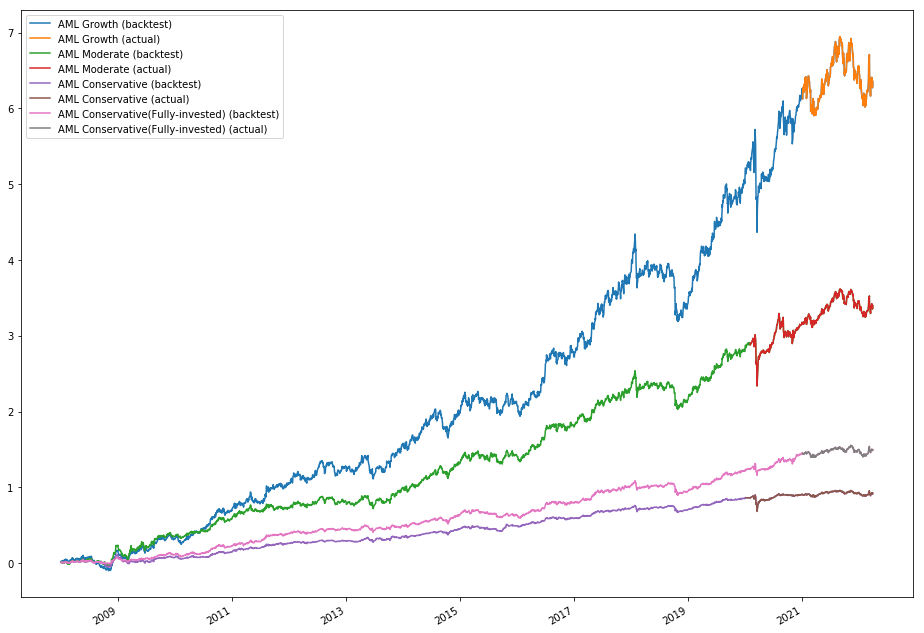

In [49]:
cum_retrun.plot(figsize=(16, 12))

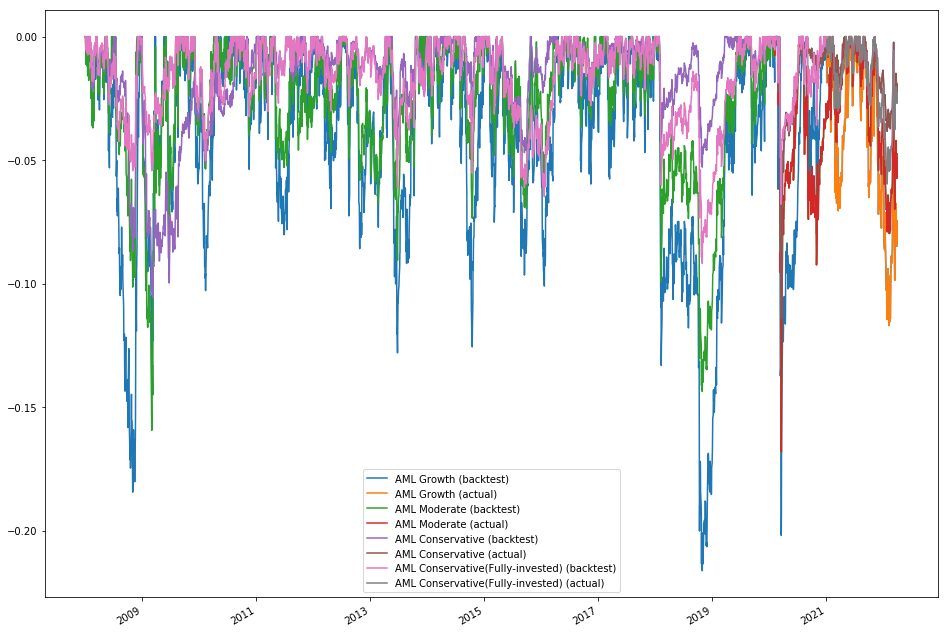

In [50]:
drawdown.plot(figsize=(16, 12))

In [51]:
base_client = 'Moderate'
base_client_cum_retrun = cum_retrun["AML " + base_client + " (backtest)"]
base_client_cum_retrun.name = "AML " + base_client

tlt = get_price2return(tlt_price_file)
tlt = tlt.pct_change().dropna()
tlt = tlt[tlt.index >= base_client_cum_retrun.index[0]]
tlt = tlt[tlt.index <= base_client_cum_retrun.index[-1]]
cum_return_tlt = empy.cum_returns(tlt)
cum_return_tlt.name = '20 years (TLT)'

tnx = get_price2return(tnx_price_file)
tnx = tnx / 100
tnx = tnx.pct_change().dropna()
tnx = tnx[tnx.index >= base_client_cum_retrun.index[0]]
tnx = tnx[tnx.index <= base_client_cum_retrun.index[-1]]
# tnx = tnx - 1
cum_return_tnx = empy.cum_returns(tnx)
cum_return_tnx.name = '10 years (TNX)'

# cum_retrun2 = pd.concat([tlt, tnx], axis=1)
cum_retrun2 = pd.concat([base_client_cum_retrun, cum_return_tlt, cum_return_tnx], axis=1)
cum_retrun2

AML Moderate  20 years (TLT)  10 years (TNX)
2008-01-02      0.013971        0.014402       -0.033209
2008-01-03      0.017116        0.013005       -0.033209
2008-01-04      0.009873        0.013220       -0.044857
2008-01-07      0.005679        0.017627       -0.048575
2008-01-08      0.009080        0.016445       -0.048327
...                  ...             ...             ...
2022-03-24      3.406290             NaN             NaN
2022-03-25      3.398975             NaN             NaN
2022-03-28      3.351174             NaN             NaN
2022-03-29      3.367249             NaN             NaN
2022-03-30      3.397016             NaN             NaN

[3587 rows x 3 columns]

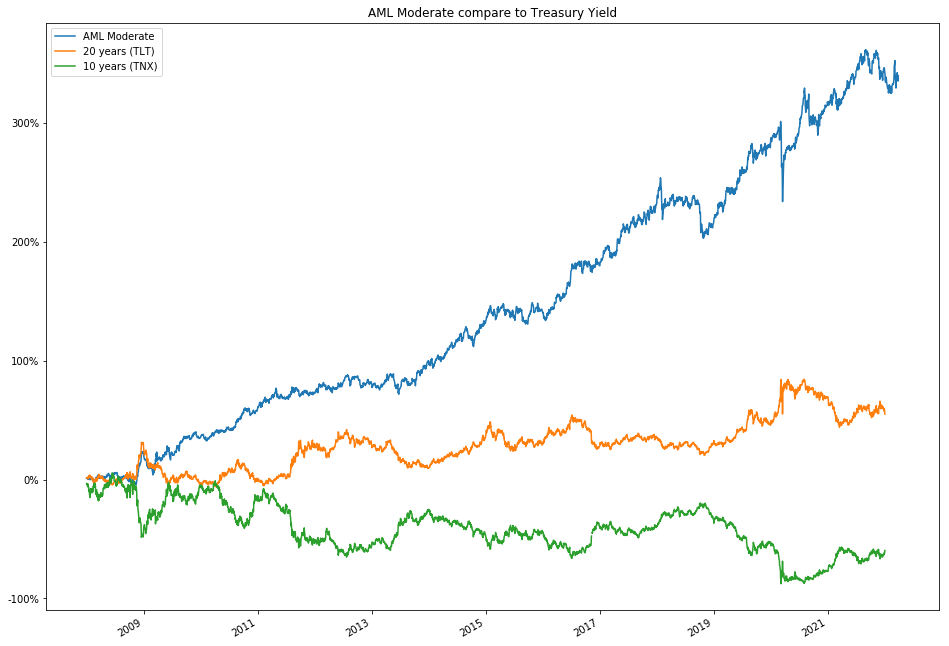

In [52]:
cum_retrun2_plot = cum_retrun2.plot(figsize=(16, 12), title="AML " + base_client + " compare to Treasury Yield")
cum_retrun2_plot.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

### lookback annualized metrics

In [53]:
lookback_period = ['INCEPTION']
metrics = pd.DataFrame()
for p in lookback_period:
#     print("===========================================")
    sub_metrics = lookback_metrics_annul(deck_daily_return, p, period_date)
    sub_metrics.index = ["{} daily".format(idx) for idx in sub_metrics.index]
    metrics = pd.concat([metrics, sub_metrics])

    sub_metrics = lookback_metrics_annul_monthly(monthly_return, p, period_date)
    sub_metrics.index = ["{} monthly".format(idx) for idx in sub_metrics.index]
    metrics = pd.concat([metrics, sub_metrics])
metrics

lookback_period:  INCEPTION  sub_df[0]:  2008-01-02 00:00:00  sub_df[-1]:  2022-03-30 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  (2008, 1)  sub_df[-1]:  (2022, 3)


AML Growth AML Moderate AML Conservative  \
INCEPTION RETURN daily            0.150463     0.109645        0.0469264   
INCEPTION Volatility daily        0.142022     0.107467         0.053263   
INCEPTION SHARPE RATIO daily       1.05827      1.02205         0.887709   
INCEPTION Max-DD daily           -0.216259    -0.168162        -0.114088   
INCEPTION STD daily             0.00894653   0.00676976       0.00335525   
INCEPTION Total Return daily       6.35307      3.39702          0.92083   
INCEPTION worst return daily     -0.052762   -0.0492225       -0.0326912   
INCEPTION RETURN monthly          0.150283     0.109517        0.0468729   
INCEPTION Volatility monthly      0.137337     0.106942        0.0549448   
INCEPTION SHARPE RATIO monthly     1.09295      1.02826         0.862396   
INCEPTION Max-DD monthly         -0.171566    -0.119708       -0.0816379   
INCEPTION STD monthly            0.0396457    0.0308715        0.0158612   
INCEPTION Total Return monthly     6.35307      3.39702          0.92083   
INCEPTION worst return monthly   -0.109465   -0.0968826       -0.0677496   

                               AML Conservative(Fully-invested)  
INCEPTION RETURN daily                                0.0663396  
INCEPTION Volatility daily                            0.0609583  
INCEPTION SHARPE RATIO daily                            1.08433  
INCEPTION Max-DD daily                               -0.0918277  
INCEPTION STD daily                                  0.00384001  
INCEPTION Total Return daily                            1.49499  
INCEPTION worst return daily                         -0.0268491  
INCEPTION RETURN monthly                              0.0662633  
INCEPTION Volatility monthly                          0.0579273  
INCEPTION SHARPE RATIO monthly                          1.13929  
INCEPTION Max-DD monthly                             -0.0684994  
INCEPTION STD monthly                                 0.0167222  
INCEPTION Total Return monthly                          1.49499  
INCEPTION worst return monthly                       -0.0608664

## Generate real metircs

In [54]:
real_daily_return = deck_daily_return[deck_daily_return.index >= ib_df.index[0]]
real_daily_return = real_daily_return[real_daily_return.index <= ib_df.index[-1]]
# real_daily_return = real_daily_return[ib_df.index]

real_cum_retrun = pd.DataFrame()
real_drawdown = pd.DataFrame()
real_metrics = pd.DataFrame()
real_monthly_return = pd.DataFrame()
for col in real_daily_return.columns:
    # cumulative returns
    cum_return_client = empy.cum_returns(real_daily_return[col].dropna())
    real_cum_retrun[col] = cum_return_client
    
    # daily drawdown
    drawdown_client = drawdown_from_return(real_daily_return[col].dropna().fillna(0))
    real_drawdown[col] = drawdown_client
    
    real_monthly_return[col] = empy.aggregate_returns(
        real_daily_return[col].dropna(), convert_to='monthly')

In [36]:
base = '60 Equities & 40 Bonds'

real_cum_retrun = pd.DataFrame()
real_drawdown = pd.DataFrame()
real_metrics = pd.DataFrame()
real_monthly_return = pd.DataFrame()

# real_daily_return = deck_daily_return.loc[real_dates, :]
bm = real_daily_return[base]
for col in real_daily_return.columns:
    if col.startswith("AML"):
        
        ib_part = ib_df[col].dropna()
        tmp_ib_part = ib_part[ib_part != 0] 
        first_ib_date = tmp_ib_part.index[0]
        bm_part = bm[bm.index < first_ib_date]
        join_ib = ib_part[ib_part.index >= first_ib_date]
        joined_part = pd.concat([bm_part, join_ib])
        real_daily_return[col] = joined_part
        
        cum_return_client = empy.cum_returns(real_daily_return[col].fillna(0))
        cum_return_client = cum_return_client[cum_return_client.index >= first_ib_date]
#         cum_return_client.name = col
#         real_cum_retrun = pd.concat([real_cum_retrun, cum_return_client], axis=1)
        
        drawdown_client = drawdown_from_return(real_daily_return[col].fillna(0))
        drawdown_client = drawdown_client[drawdown_client.index >= first_ib_date]
#         drawdown_client.name = col
#         real_drawdown = pd.concat([real_drawdown, drawdown_client], axis=1)
        
        real_monthly_return[col] = empy.aggregate_returns(
            ib_part.fillna(0), convert_to='monthly')
    else:
        real_monthly_return[col] = empy.aggregate_returns(
            real_daily_return[col].fillna(0), convert_to='monthly')
    
        cum_return_client = empy.cum_returns(real_daily_return[col].fillna(0))
        drawdown_client = drawdown_from_return(real_daily_return[col].fillna(0))
    real_cum_retrun[col] = cum_return_client
    real_drawdown[col] = drawdown_client

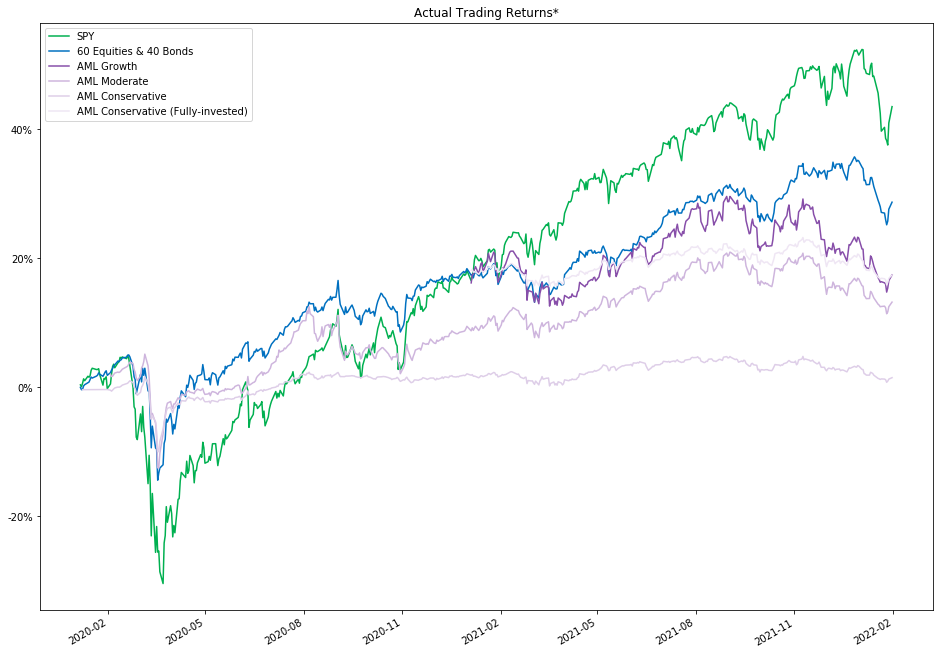

In [37]:
real_cr = real_cum_retrun.plot(figsize=(16, 12), color=colors, title='Actual Trading Returns*')
real_cr.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

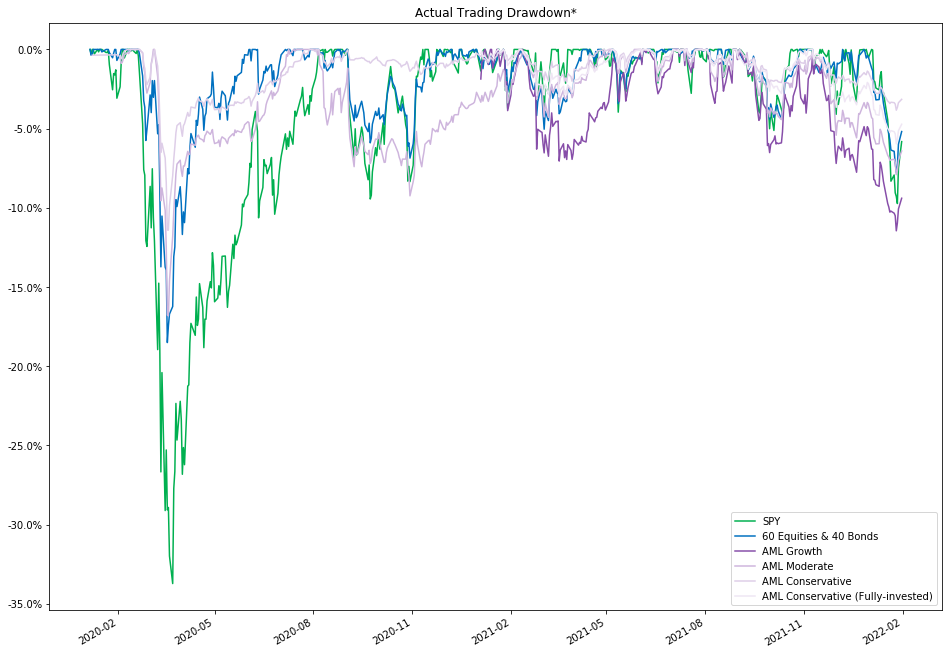

In [38]:
real_dd = real_drawdown.plot(figsize=(16, 12), color=colors, title='Actual Trading Drawdown*')
real_dd.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

### lookback annualized metrics

In [39]:
ib_df = ib_df[clients]
real_daily_return = ib_df[ib_df.index < datetime.strptime(period_date, '%Y-%m-%d')]
# real_daily_return = ib_df.loc[ib_df.index < datetime.strptime(period_date, '%Y-%m-%d')]

benchmark_return = deck_daily_return[benchmark]
# benchmark_return = benchmark_return.loc[real_daily_return.index, :]
benchmark_return = benchmark_return[benchmark_return.index <= real_daily_return.index[-1]]
real_daily_return = pd.concat([benchmark_return, real_daily_return], axis=1)

lookback_period = ['INCEPTION']
real_metrics = pd.DataFrame()
for p in lookback_period:
#     print("===========================================")
    sub_metrics = lookback_A2ACompare(real_daily_return, p, benchmark, period_date)
    sub_metrics.index = ["{} daily".format(idx) for idx in sub_metrics.index]
    real_metrics = pd.concat([real_metrics, sub_metrics])
    
    sub_metrics = lookback_A2ACompare_monthly(real_monthly_return, p, benchmark, period_date)
    sub_metrics.index = ["{} monthly".format(idx) for idx in sub_metrics.index]
    real_metrics = pd.concat([real_metrics, sub_metrics])
real_metrics

lookback_period:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  2020-02-03 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-02-03 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  2020-01-06 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-01-06 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2022-01-31 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  (2020, 12)  sub_df[-1]:  (2022, 1)
lookback_period with benchmark:  INCEPTION  sub_df[0]:  (2020, 2)  sub_df[-1]:  (2022, 1)

SPY 60 Equities & 40 Bonds  AML Growth  \
INCEPTION RETURN daily            0.202662              0.0837967 -0.00756619   
INCEPTION Volatility daily        0.135418              0.0920155    0.129322   
INCEPTION SHARPE RATIO daily       1.43074               0.920571  0.00598965   
INCEPTION Max-DD daily          -0.0972766             -0.0776839   -0.114498   
INCEPTION STD daily             0.00853053             0.00579643  0.00814653   
INCEPTION Total Return daily      0.221299              0.0910889 -0.00819412   
INCEPTION worst return daily    -0.0244405             -0.0212323  -0.0398023   
INCEPTION RETURN monthly          0.219199              0.0901316 -0.00702765   
INCEPTION Volatility monthly      0.124257              0.0990287    0.112449   
INCEPTION SHARPE RATIO monthly     1.66594               0.920671  -0.0101607   
INCEPTION Max-DD monthly        -0.0527413             -0.0473003  -0.0881166   
INCEPTION STD monthly              0.03587              0.0285871   0.0324613   
INCEPTION Total Return monthly    0.260144               0.105924 -0.00819412   
INCEPTION worst return monthly  -0.0527413             -0.0473003  -0.0591214   

                                      SPY 60 Equities & 40 Bonds AML Moderate  \
INCEPTION RETURN daily           0.199358               0.124182    0.0543123   
INCEPTION Volatility daily       0.255332               0.137883     0.110909   
INCEPTION SHARPE RATIO daily     0.840706               0.918358     0.532616   
INCEPTION Max-DD daily          -0.337173              -0.185036    -0.168162   
INCEPTION STD daily             0.0160844             0.00868579    0.0069866   
INCEPTION Total Return daily     0.438459               0.263784     0.111574   
INCEPTION worst return daily    -0.109424             -0.0531484   -0.0492225   
INCEPTION RETURN monthly         0.199358               0.124182    0.0543123   
INCEPTION Volatility monthly     0.200208                0.12205     0.102889   
INCEPTION SHARPE RATIO monthly    1.01125                1.02158      0.56412   
INCEPTION Max-DD monthly        -0.194151             -0.0693722   -0.0744002   
INCEPTION STD monthly           0.0577951              0.0352327    0.0297016   
INCEPTION Total Return monthly   0.438459               0.263784     0.111574   
INCEPTION worst return monthly  -0.124871             -0.0494161   -0.0390391   

                                      SPY 60 Equities & 40 Bonds  \
INCEPTION RETURN daily           0.190252               0.129359   
INCEPTION Volatility daily       0.251648                0.13568   
INCEPTION SHARPE RATIO daily     0.818975               0.964924   
INCEPTION Max-DD daily          -0.337173              -0.185036   
INCEPTION STD daily             0.0158523             0.00854706   
INCEPTION Total Return daily     0.435425               0.287204   
INCEPTION worst return daily    -0.109424             -0.0531484   
INCEPTION RETURN monthly         0.189462               0.128836   
INCEPTION Volatility monthly     0.196433               0.119613   
INCEPTION SHARPE RATIO monthly   0.984301                1.07506   
INCEPTION Max-DD monthly        -0.195851             -0.0693722   
INCEPTION STD monthly           0.0567054              0.0345293   
INCEPTION Total Return monthly   0.435425               0.287204   
INCEPTION worst return monthly  -0.124871             -0.0494161   

                               AML Conservative         SPY  \
INCEPTION RETURN daily               0.00898392    0.202662   
INCEPTION Volatility daily            0.0567652    0.135418   
INCEPTION SHARPE RATIO daily           0.186034     1.43074   
INCEPTION Max-DD daily                -0.114088  -0.0972766   
INCEPTION STD daily                  0.00357587  0.00853053   
INCEPTION Total Return daily          0.0187353    0.221299   
INCEPTION worst return daily         -0.0326912  -0.0244405   
INCEPTION RETURN monthly             0.00894954    0.219199   
INCEPTION Volatilit

### save metrics record

In [55]:
period_return_fn = os.path.join(result_fn, 'period_return.xlsx')
with pd.ExcelWriter(period_return_fn) as writer:
    for k, df in period_return_dict.items():
        df.to_excel(writer, sheet_name=k[:30])
    quarterly_return.to_excel(writer, sheet_name='quarterly_return')
        
monthly_sharpe_fn = os.path.join(result_fn, 'monthly_sharpe.xlsx')
with pd.ExcelWriter(monthly_sharpe_fn) as writer:
    for k, df in monthly_sharpe_dict.items():
        df.to_excel(writer, sheet_name=k[:30])

overall_perf_fn = os.path.join(result_fn, 'overall_perf_fn.xlsx')
with pd.ExcelWriter(overall_perf_fn) as writer:
    cum_retrun.to_excel(writer, sheet_name='cum_retrun')
    drawdown.to_excel(writer, sheet_name='drawdown')
    metrics.to_excel(writer, sheet_name='lookback_metrics')

    real_cum_retrun.to_excel(writer, sheet_name='real_cum_retrun')
    real_drawdown.to_excel(writer, sheet_name='real_drawdown')
    real_metrics.to_excel(writer, sheet_name='real_lookback_metrics')

## compare performance between simulation and benchmark

In [39]:
def performance(temp, period='month'):
    temp.index = pd.to_datetime(temp.index)
    if period == 'month':
        periodlist = list(set(temp.index.strftime('%Y-%m')))#.unique()
    elif period == 'year':
        periodlist = list(set(temp.index.strftime('%Y')))#.unique()
    periodlist.sort()
    print(periodlist)
    maxdd = []
    ret = []
    for per in periodlist:
        #print('per', per)
        #print('temp[per]', temp[per])
        maxdd.append(temp[per].agg([empy.max_drawdown]).values.tolist()[0])
#         ret.append(temp[per].agg([emp.annual_return]).values.tolist()[0]) # Annual Return
        ret.append(temp[per].agg([empy.cum_returns]).values.tolist()[-1]) # Monthly Return
        
    maxddframe = pd.DataFrame(maxdd)
    maxddframe.index = periodlist
    maxddframe.columns = temp.columns
    
    retframe = pd.DataFrame(ret)
    retframe.index = periodlist
    retframe.columns = temp.columns
    
    return maxddframe, retframe

def ranklist(maxddframe, retframe, client):
    rank = maxddframe.rank(axis=1, ascending=False)
    maxdd = list(rank[rank[client]==1].index)

    rank = retframe.rank(axis=1, ascending=False)
    ret = list(rank[rank[client]==1].index)
    return list(set(maxdd) & set(ret))

def better_perf(client, benchmark, df, real, colors):
    temp = pd.concat([df[benchmark], real[client]], axis=1).dropna()
    print(temp)
    maxddframe, retframe = performance(temp)
    maxdd = maxddframe.plot(kind='bar', figsize=(12,10), color=colors, title='Max Drawdowm')
    maxdd.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ret = retframe.plot(kind='bar', figsize=(12,10), color=colors, title='Monthly Return')
    ret.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    print("In this period, {} has a better performance.".format(client))
    rank = ranklist(maxddframe, retframe, client=client)
    rank.sort()
    print(rank)
    if len(rank)>0:
        maxdd = maxddframe.loc[rank].plot(kind='bar', figsize=(12,10), color=colors, title='Max Drawdowm (Outperformance)')
        maxdd.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
        ret = retframe.loc[rank].plot(kind='bar', figsize=(12,10), color=colors, title='Monthly Return (Outperformance)')
        ret.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

                 SPY  60 Equities & 40 Bonds  AML Growth
2020-12-31  0.005081                0.003672    0.000000
2021-01-04 -0.013614               -0.008650   -0.018649
2021-01-05  0.006887                0.001119    0.010802
2021-01-06  0.005978               -0.004613    0.001070
2021-01-07  0.014857                0.005550    0.006055
...              ...                     ...         ...
2021-11-23  0.001326               -0.004893    0.000631
2021-11-24  0.002670                0.007893    0.002822
2021-11-26 -0.022303               -0.003591   -0.022965
2021-11-29  0.012267                0.004049   -0.000653
2021-11-30 -0.019458               -0.005599   -0.012474

[231 rows x 3 columns]
['2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11']
In this period, AML Growth has a better performance.
['2021-05']
                 SPY  60 Equities & 40 Bonds  AML Moderate
2020-02-03  0.007429               

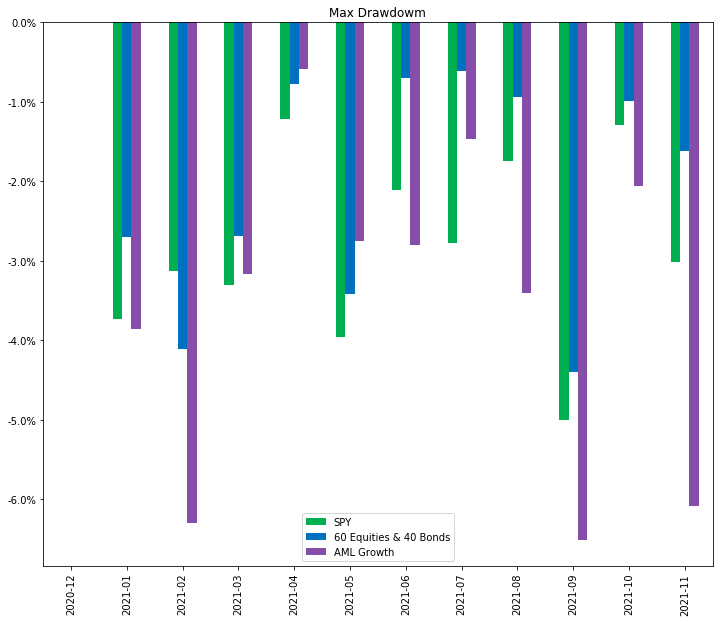

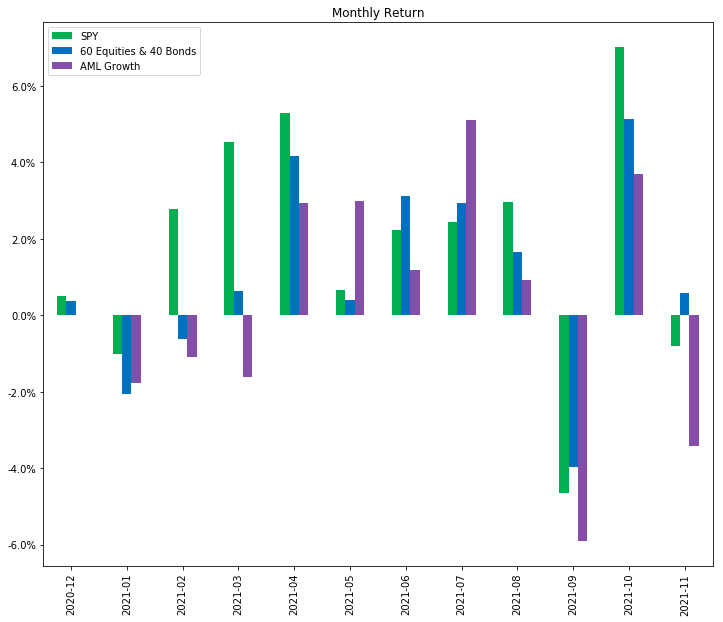

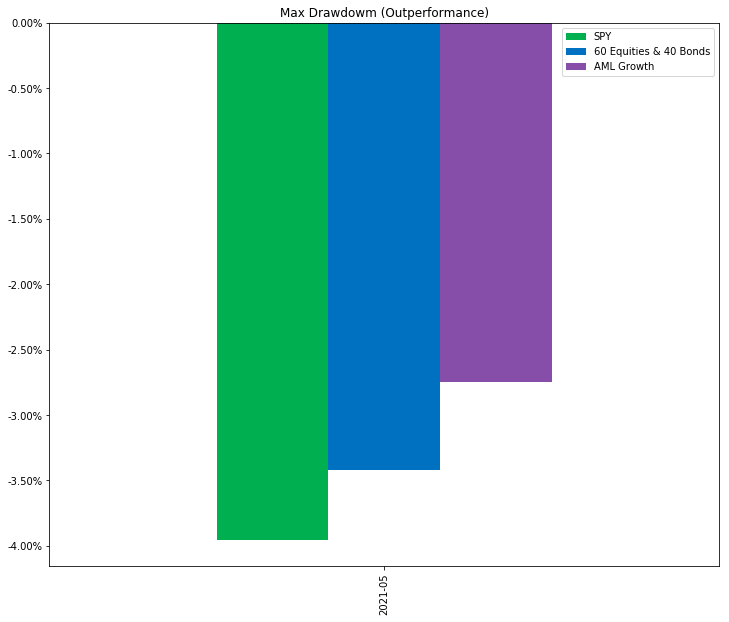

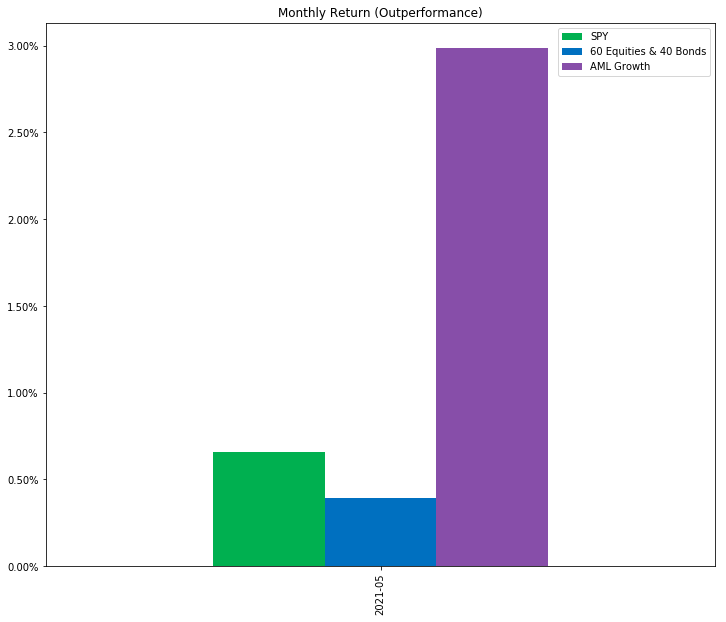

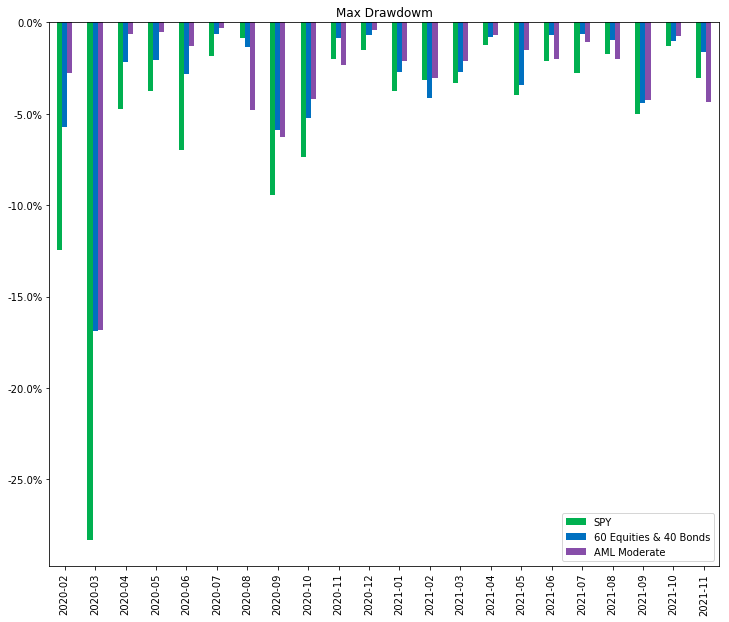

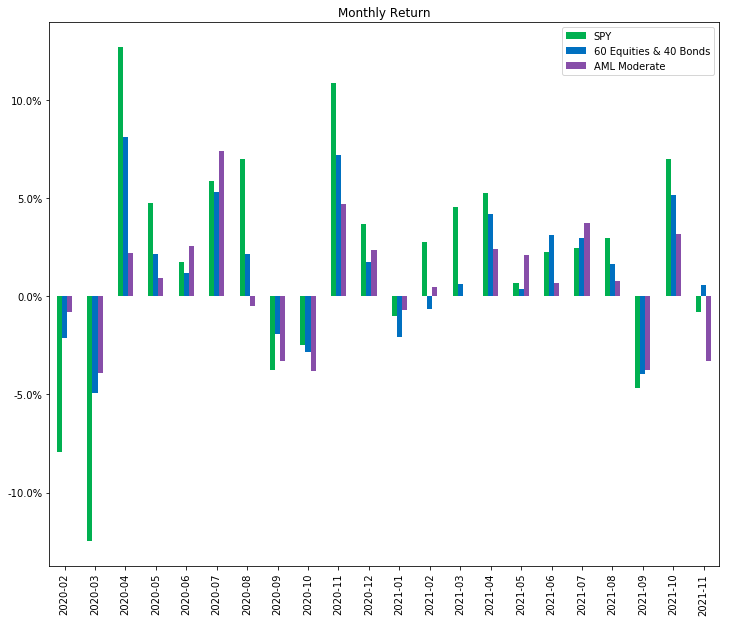

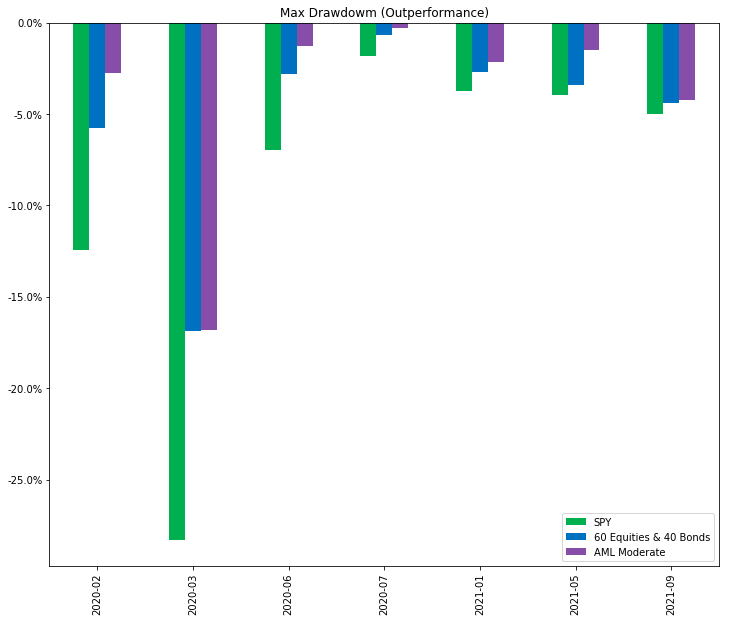

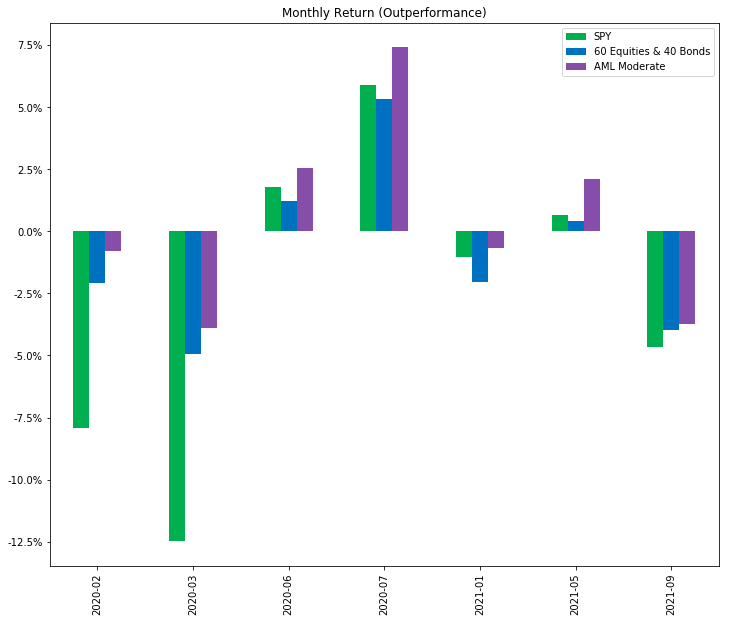

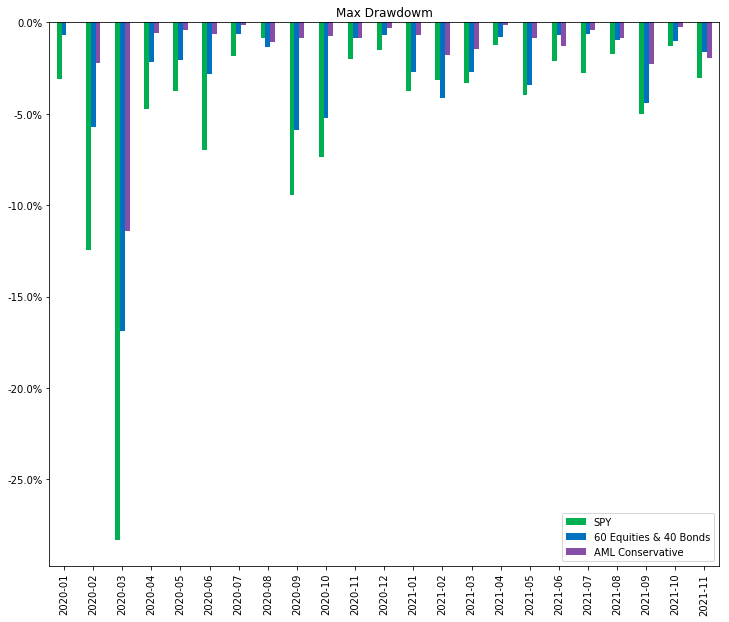

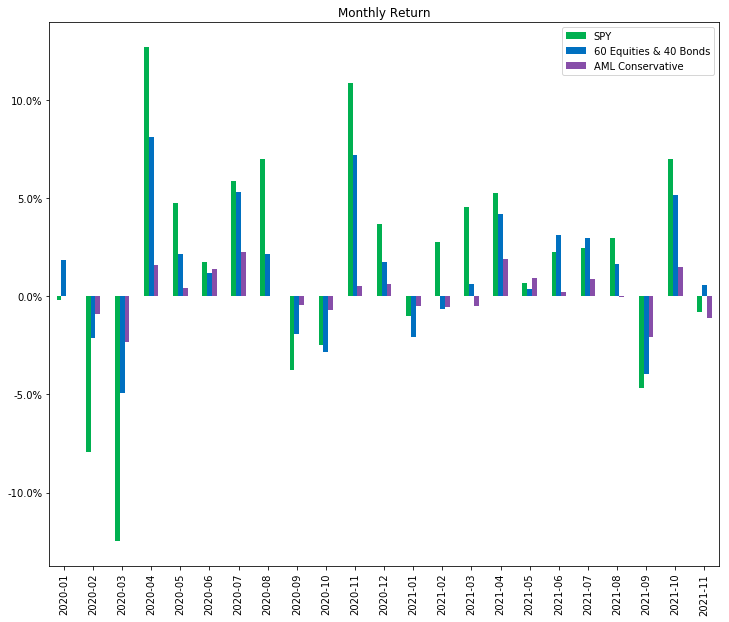

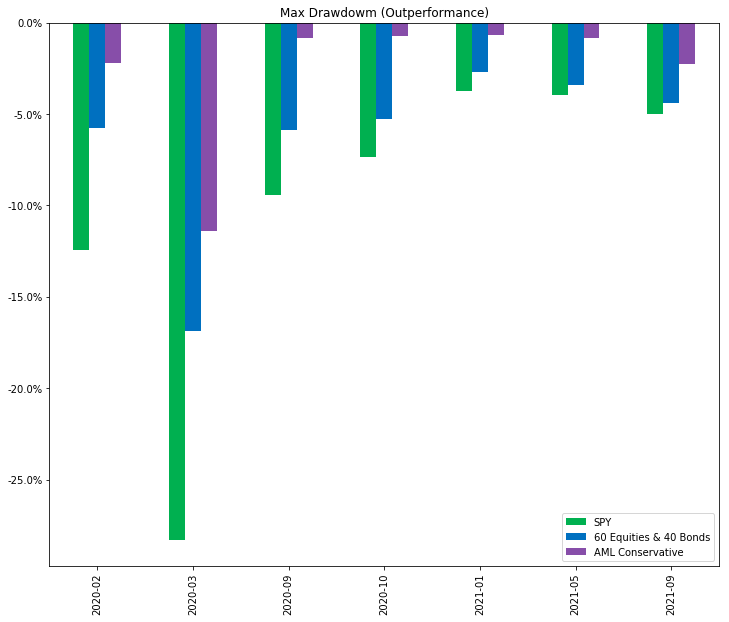

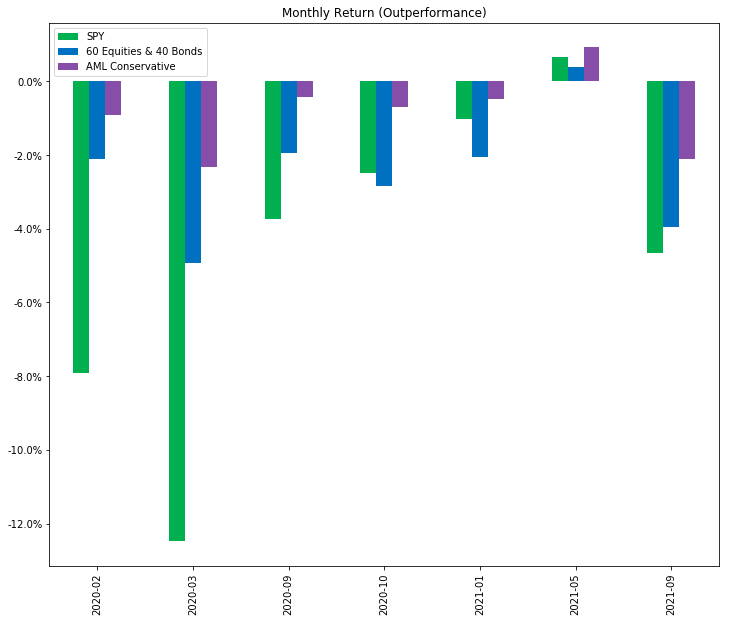

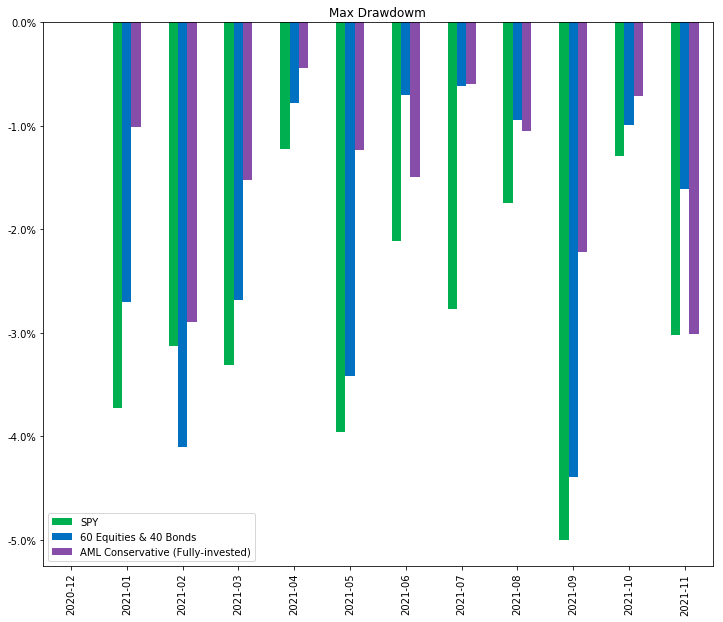

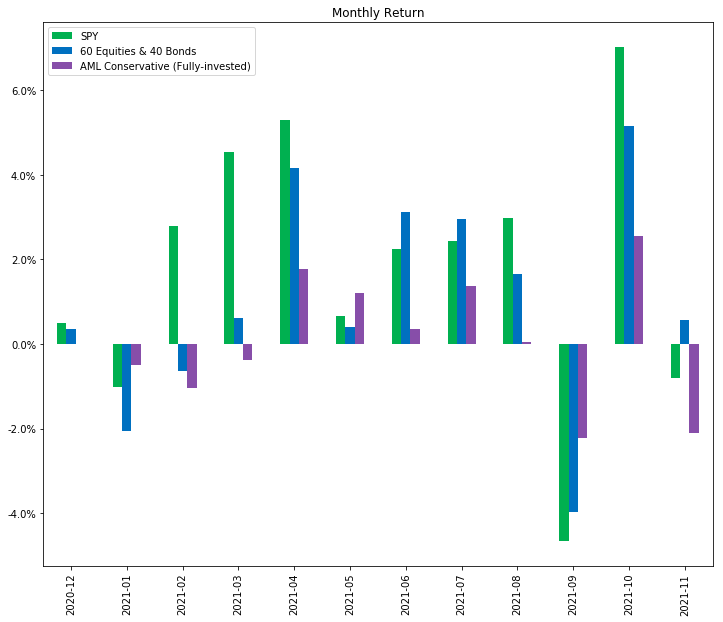

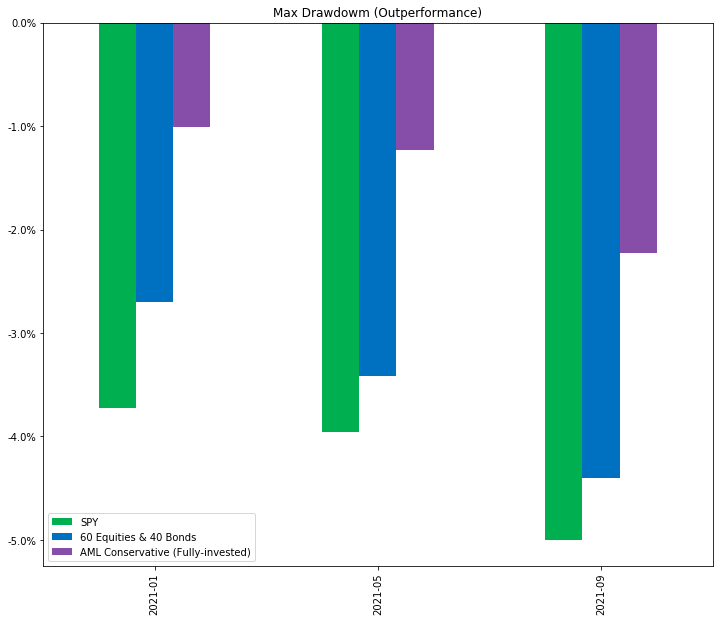

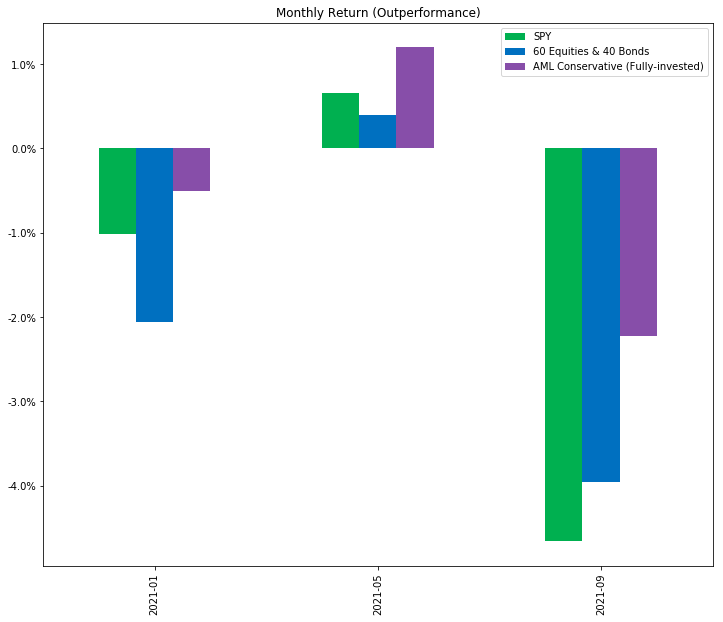

In [40]:
for client in clients:
    better_perf(client, benchmark, sim_df, ib_df, colors)

## Return Contribution

In [41]:
price = pd.read_csv(backtest_price, index_col=0)
price = pd.pivot_table(price,'adj_close','date','code').ffill()
price.index = pd.to_datetime(price.index)
ret = price.pct_change()

In [42]:
def plot_stack(df, sorted_index=None, title='', figsize=(16,9)):
    
    if sorted_index is None:
        sorted_index = df.sum().sort_values().index
    
    cm = plt.get_cmap('tab20')
    NUM_COLORS = len(sorted_index)
    color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    ax.set_prop_cycle(color=color[::-1])
    df1 = df.reindex(sorted_index[::-1], axis=1).applymap(lambda x: x if x>=0 else np.nan).fillna(0)
    df1.plot.area(ax=ax, linewidth=0)


    ax.set_prop_cycle(color=color)
    df0 = df.reindex(sorted_index, axis=1).applymap(lambda x: x if x<0 else np.nan)
    df0 = df0.rename(columns=lambda x: '_' + x)
    df0.plot.area(ax=ax, linewidth=0)


    pad = (df1.sum(axis=1).max() - df0.sum(axis=1).min())/20
    ax.set_ylim([df0.sum(axis=1).min()-pad, df1.sum(axis=1).max()+pad])
    
    
    df.sum(1).plot(ax=ax, style='k', linewidth=0.5, label='net')
    
    
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def plot_all(excel_file_name, ret, ini='2007', start='2008', end='2021'):
    
    result = {}
    
    kpi = pd.read_excel(excel_file_name, sheet_name='KPI', index_col=0)
    ykpi = pd.read_excel(excel_file_name, sheet_name='KPI(Annually)', index_col=0)
    mkpi = pd.read_excel(excel_file_name, sheet_name='KPI(Monthly)', index_col=0)
    dkpi = pd.read_excel(excel_file_name, sheet_name='KPI(Daily)', index_col=0)
    info = pd.read_excel(excel_file_name, sheet_name='Deck Info', index_col=0)
    name = info.loc['full name', :].values[0]
    
    allo = pd.read_excel(excel_file_name, sheet_name='History', index_col=0)
    allo = allo.drop(['cash','debit','aum','lev_cost','perf','commissions','asset','asset_gross'], 1)

    try:
        balance_ini = allo[ini].Balance.iloc[-1]
    except:
        balance_ini = 1e9
    allo = allo[start:end]
    
    balance_open = allo.Balance.shift().fillna(balance_ini)
    
    asset_value_close = allo.drop(['Balance'], 1)
    if int(end[:4]) < 2016:
        asset_value_close = asset_value_close.drop(['FSP','LSP','OSP','PC0',], 1)
        ret = ret.drop(['FSP','LSP','OSP','PC0',], 1)
    
    idx_allo = asset_value_close.index
    idx_ret = ret.index

    idx_common = list(set(idx_allo) & set(idx_ret))
    idx_common.sort()

    asset_value_close = asset_value_close.reindex(idx_common)
    ret_ = ret.reindex(idx_common)

    asset_value_open = asset_value_close/(1+ret_)
    asset_value_diff = asset_value_close - asset_value_open

    
    net_cum_ret = (1+ret_).cumprod()-1
    net_ret = (1+ret_).prod()-1
    net_ret.sort_values()
    
    
    net_aml_ret = asset_value_diff/balance_ini
    net_aml_cum_ret = net_aml_ret.cumsum()
    net_aml_total_ret = net_aml_ret.sum()
    net_aml_total_ret.sort_values()
    
    lev = pd.concat([(asset_value_open[a]/balance_open) for a in ret.columns], 1, keys=ret.columns)
    
    weighted_aml_ret = net_aml_ret / lev.mean()
    weighted_aml_cum_ret = weighted_aml_ret.cumsum()
    weighted_aml_total_ret = weighted_aml_ret.sum()
    weighted_aml_total_ret.sort_values()
    
    
    change_comp = pd.concat([net_ret, net_aml_total_ret, weighted_aml_total_ret],1,
          keys=['net_ret', 'net_aml_ret', 'weighted_aml_ret']).sort_index()
    title = '{} to {}'.format(start, end)
    change_comp.sort_values('net_aml_ret').plot.bar(figsize=(16,9), title=name+' '+title)
    
    
    daily_df_dict = {}
    for a in ret.columns:
        daily_df_dict[a] = pd.concat([net_cum_ret[a], net_aml_cum_ret[a], weighted_aml_cum_ret[a]],1,
              keys=['net_cum_ret', 'net_aml_cum_ret', 'weighted_aml_cum_ret'])
        ax = daily_df_dict[a][['net_cum_ret', 'weighted_aml_cum_ret']].plot(figsize=(12,6), title=a)
        ax.set_ylabel("cumulative return")
        ax.legend(loc='center right', bbox_to_anchor=(0, 1))
    
        twinx = ax.twinx()
        lev[a].plot(ax=twinx, style='r--', label='lev', alpha=0.3)
        twinx.set_ylabel("leverage")
        twinx.legend(loc='center left', bbox_to_anchor=(1, 1))
    
    # plot aml_cum_ret (stacked)
    
    net_aml_cum_ret_df = pd.DataFrame({a:daily_df_dict[a]['net_aml_cum_ret'] for a in ret.columns}).fillna(0)
    #net_aml_cum_ret_df.plot(figsize=(16,9), title=name+' cumulative aml return')
    
    plot_stack(net_aml_cum_ret_df, title=name+' cumulative aml return (stacked)')

    
    # draw down
    
    dkpi_dd = dkpi['Draw Down']
    #dkpi_dd.plot(figsize=(16,9), title='dd')
    
    dkpi_dd_all_neg = dkpi_dd[dkpi_dd<0]
    dd_idx = dkpi_dd_all_neg.index

    dkpi_dd_all_shift_neg = dkpi_dd[dkpi_dd.shift()<0]
    dd_idx_shift = dkpi_dd_all_shift_neg.index
    
    dd_idx_recover1 = list(set(dd_idx_shift)|set(dd_idx))
    dd_idx_recover1.sort()
    
    net_aml_diff = net_aml_cum_ret_df.diff()
    net_aml_diff_ = net_aml_diff.divide(balance_open/balance_ini,0)
    #net_aml_diff_
    
    net_aml_dd = net_aml_diff_.reindex(dd_idx_recover1)
    
    aml_dd = pd.DataFrame(columns=net_aml_dd.columns)
    ini = pd.Series(0, index=net_aml_dd.columns)
    tmp = ini
    for idx in dd_idx_recover1:
        tmp = tmp + (net_aml_dd.loc[idx])

        if tmp.sum()>=0:
            tmp = ini

        aml_dd.loc[idx] = tmp

    #aml_dd.sum(1).plot(figsize=(16,9))

    plot_stack(aml_dd, title=name+' draw down (stacked)')
    
    result['balance'] = allo.Balance
    result['kpi'] = kpi
    result['ykpi'] = ykpi
    result['mkpi'] = mkpi
    result['dkpi'] = dkpi
    result['lev'] = lev
    result['net_aml_cum_ret_df'] = net_aml_cum_ret_df
    
    return result, name


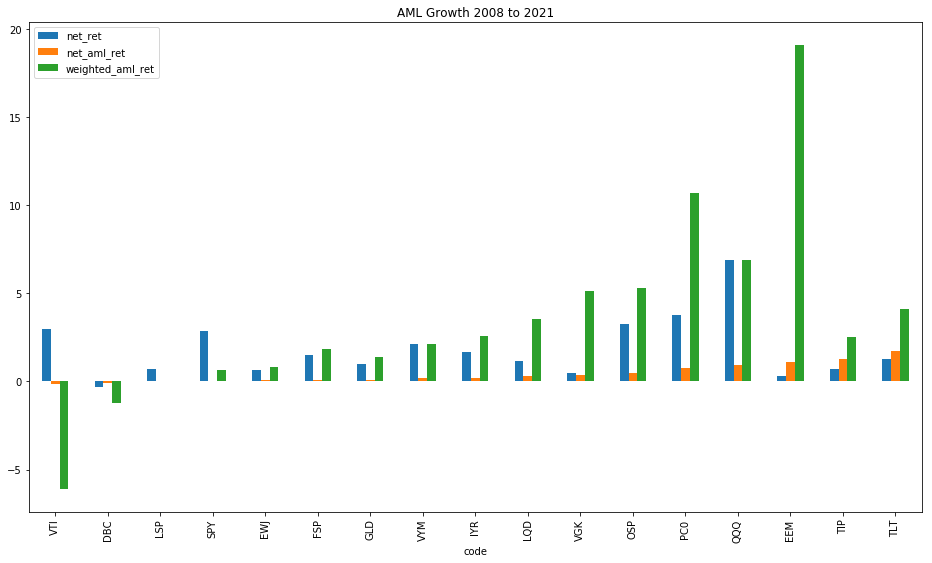

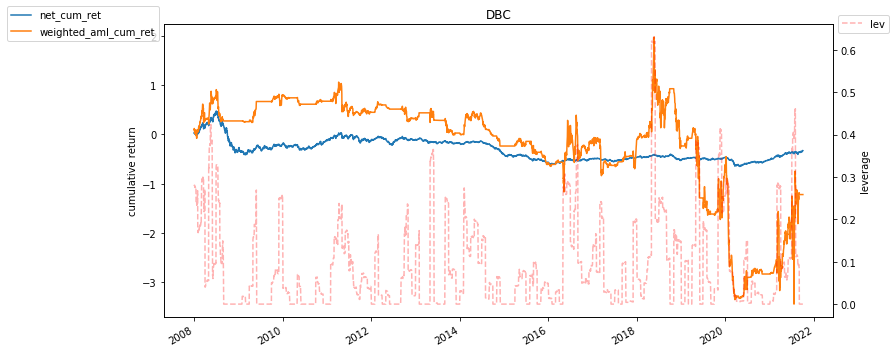

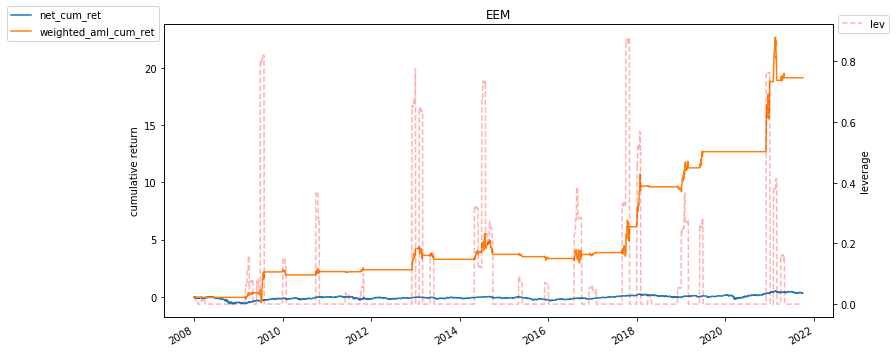

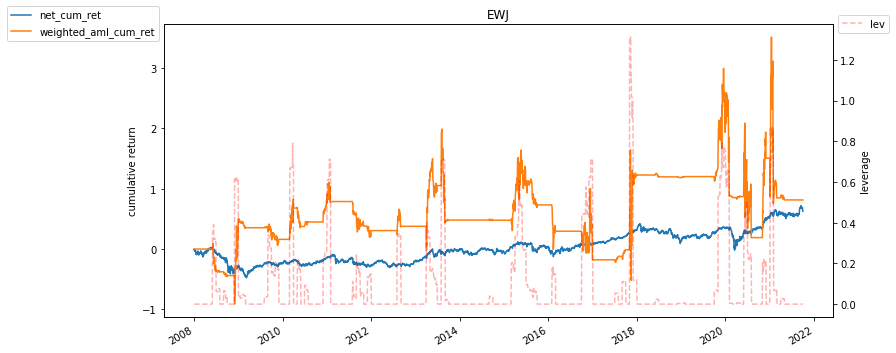

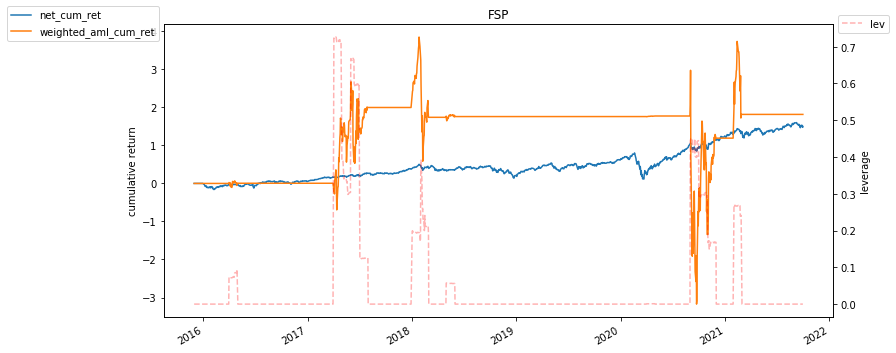

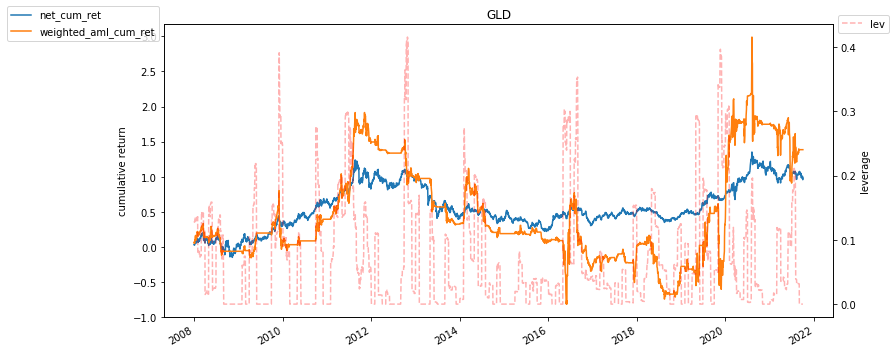

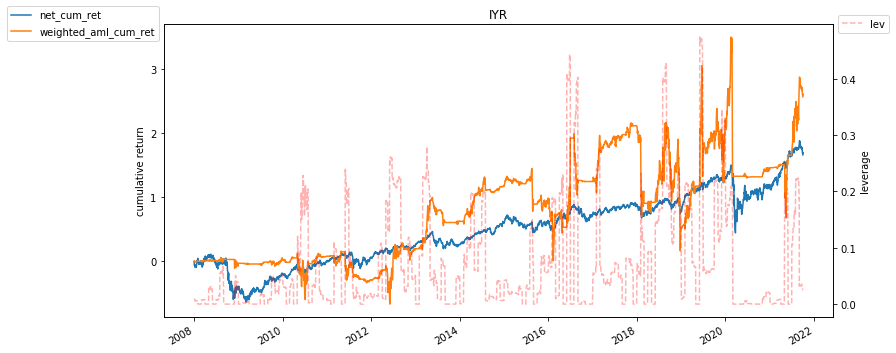

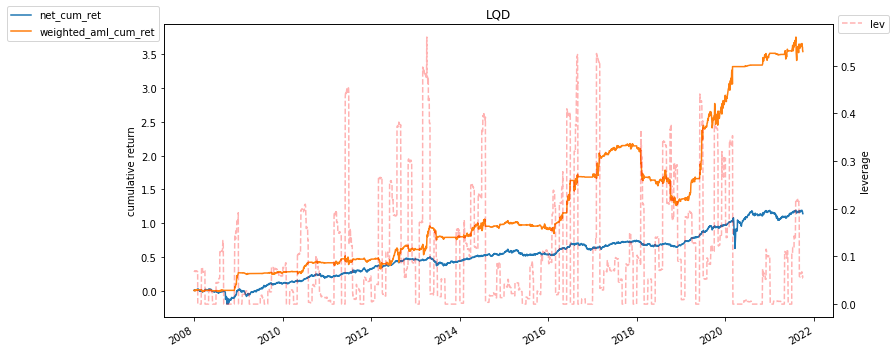

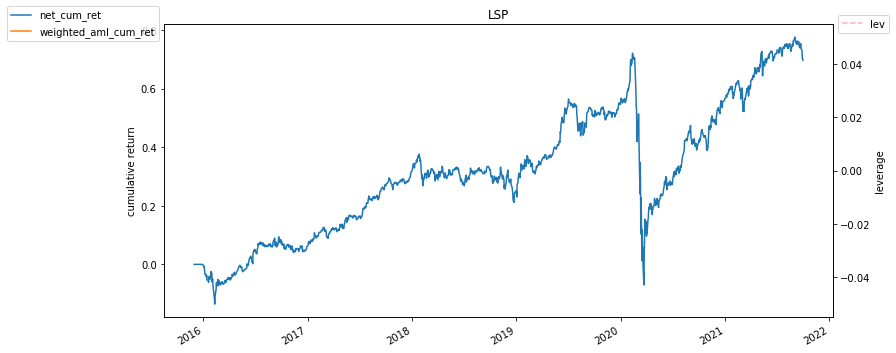

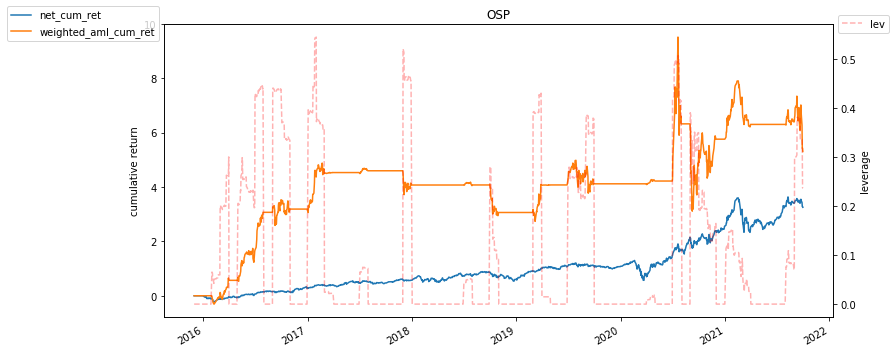

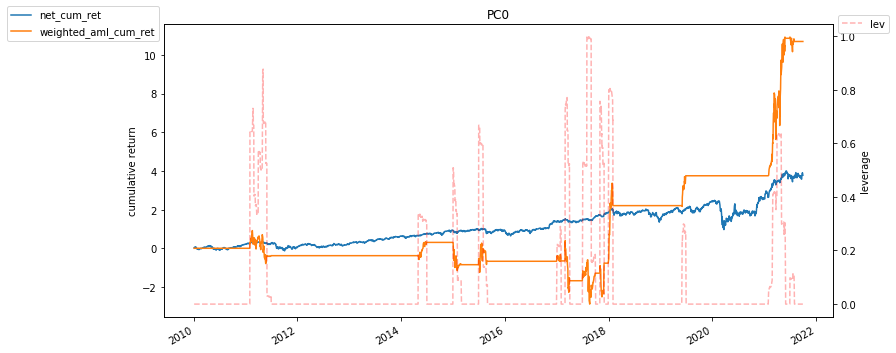

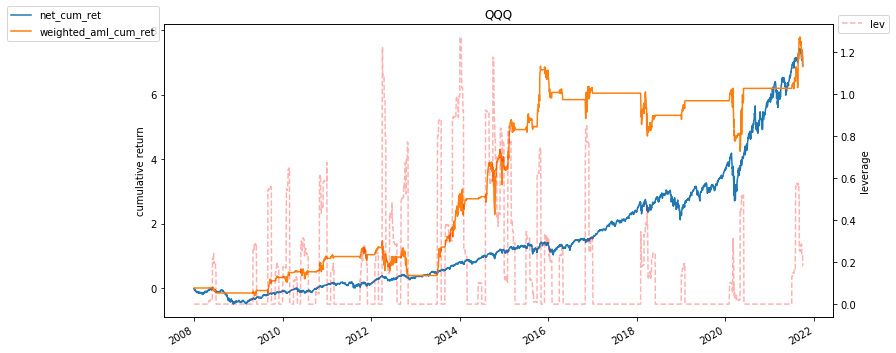

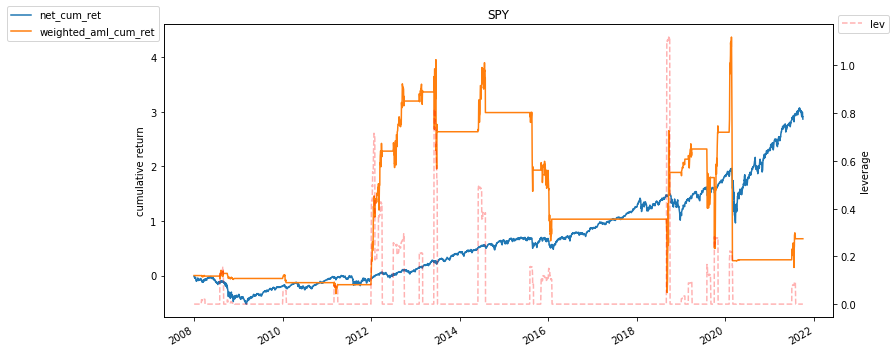

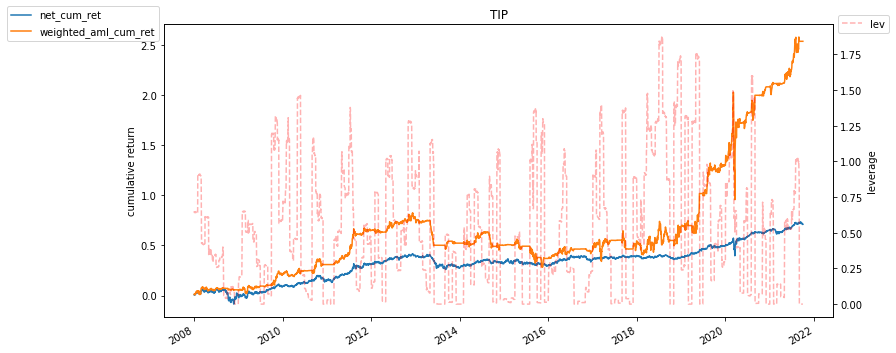

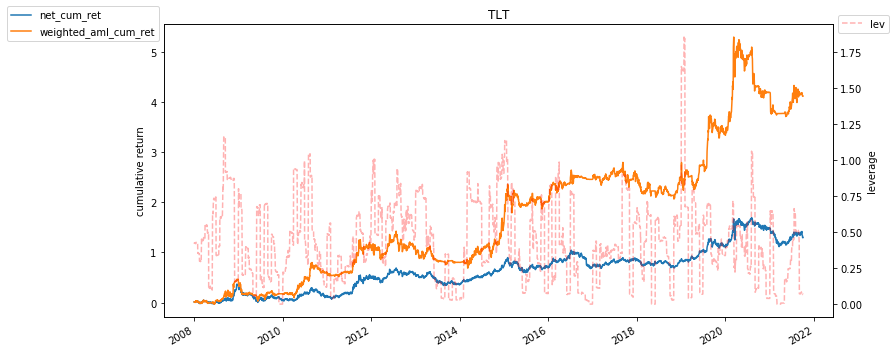

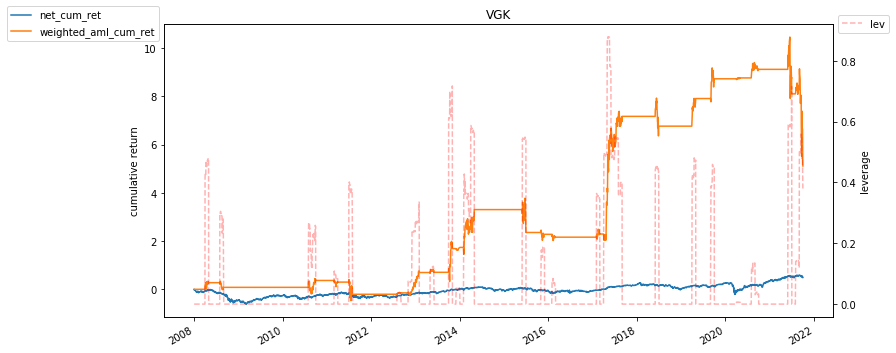

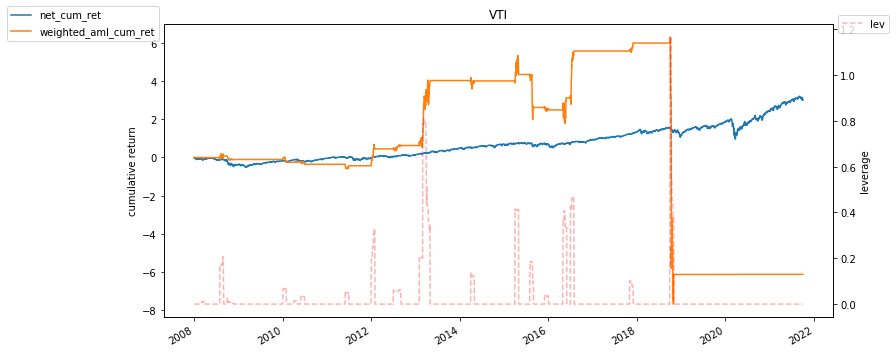

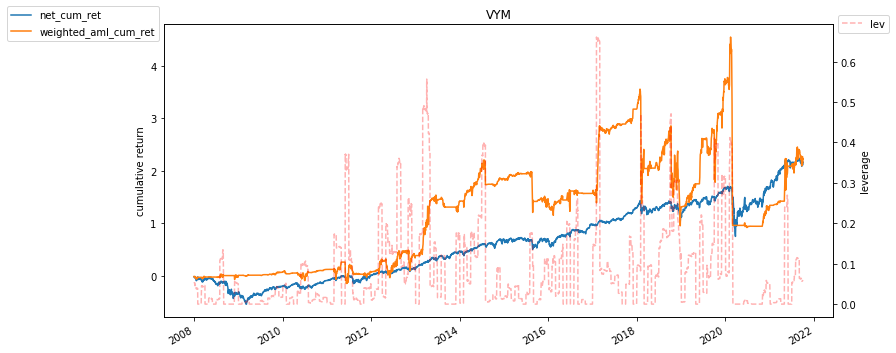

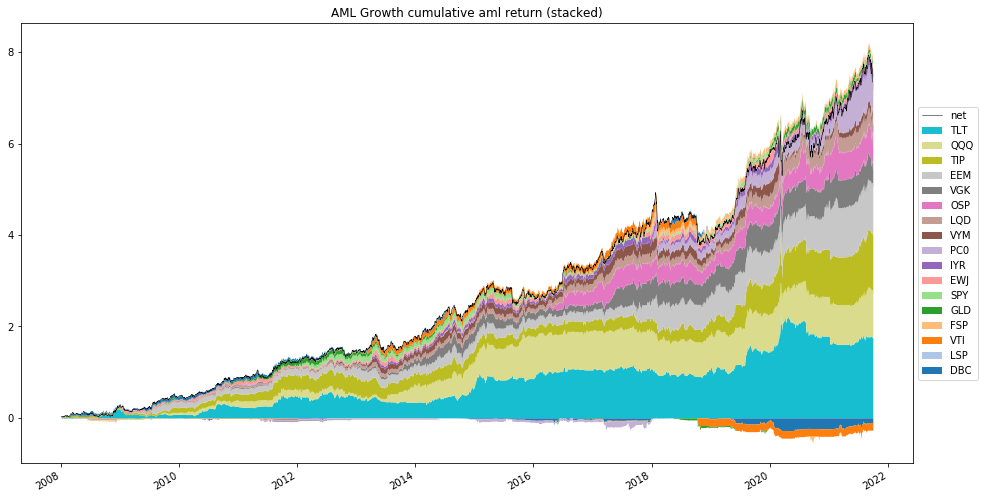

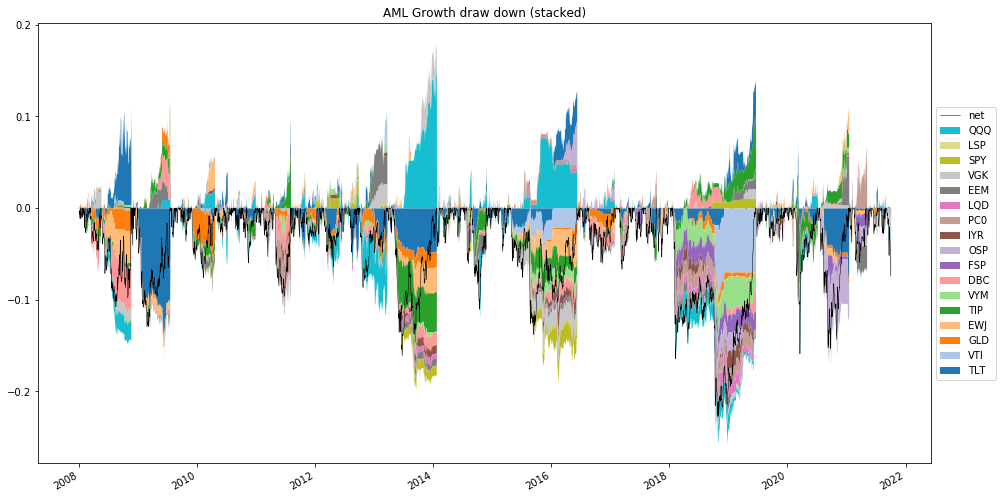

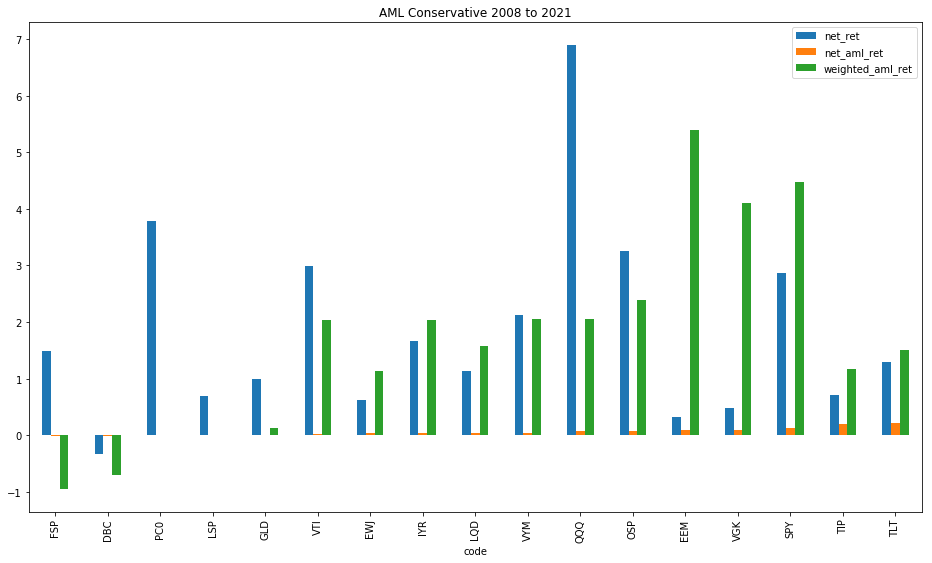

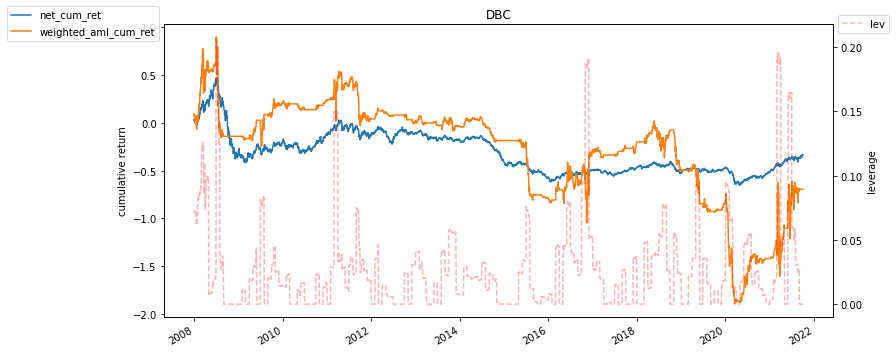

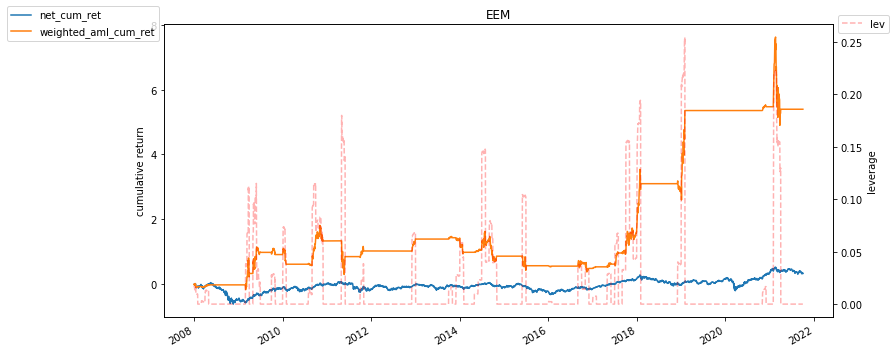

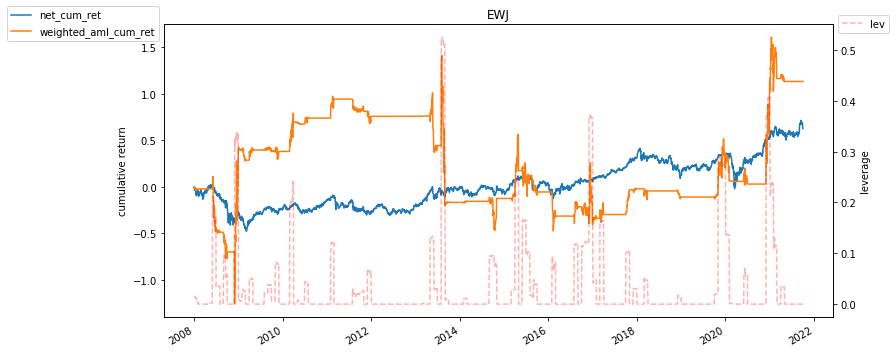

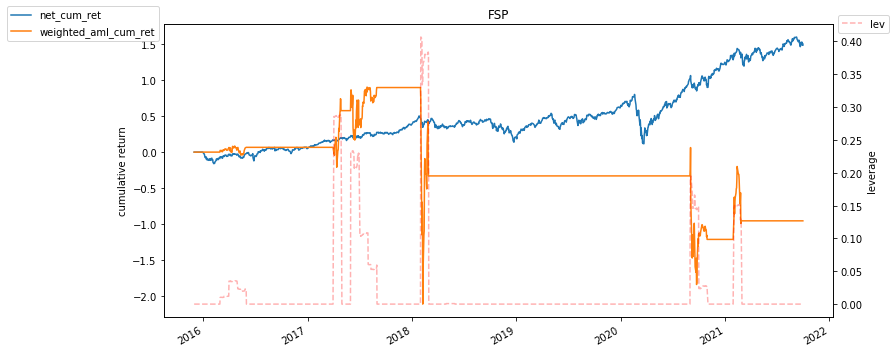

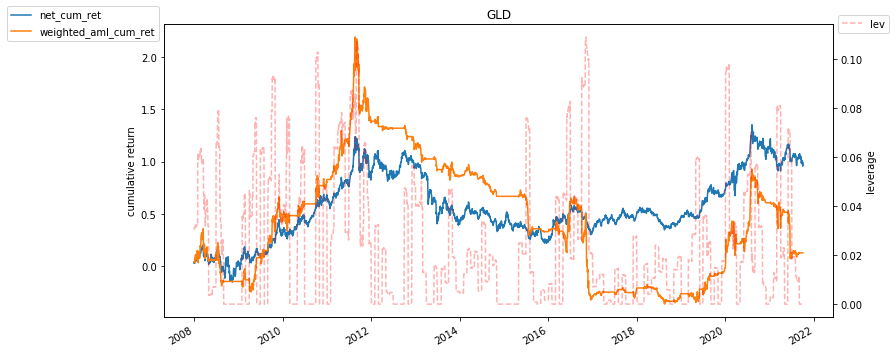

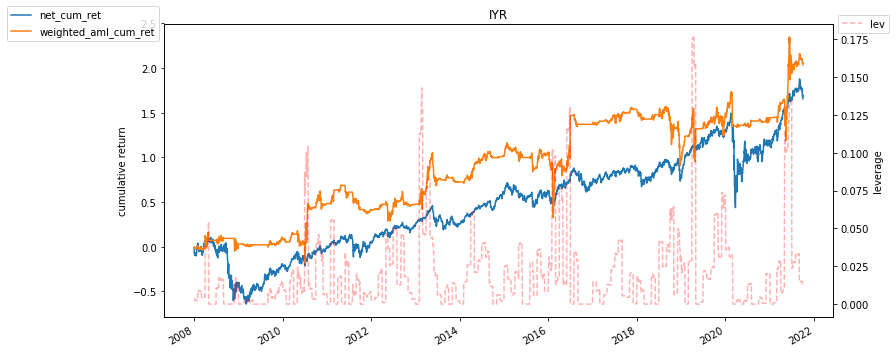

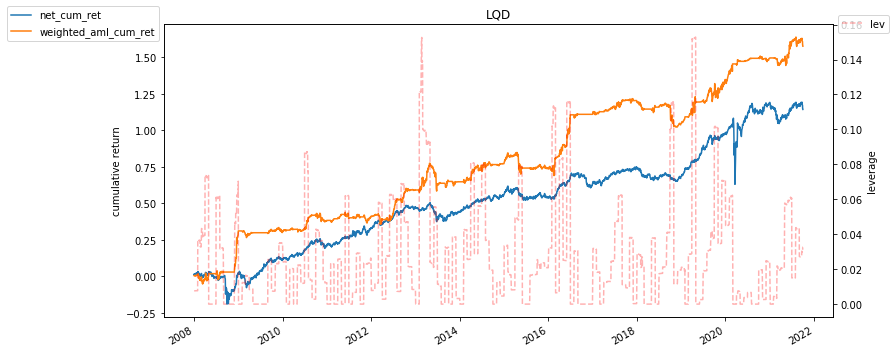

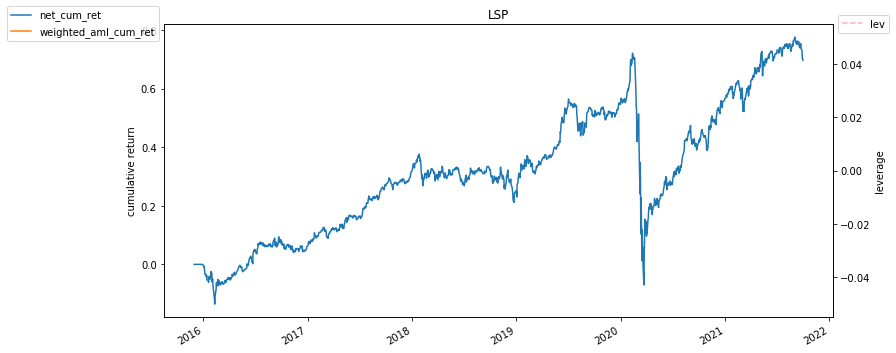

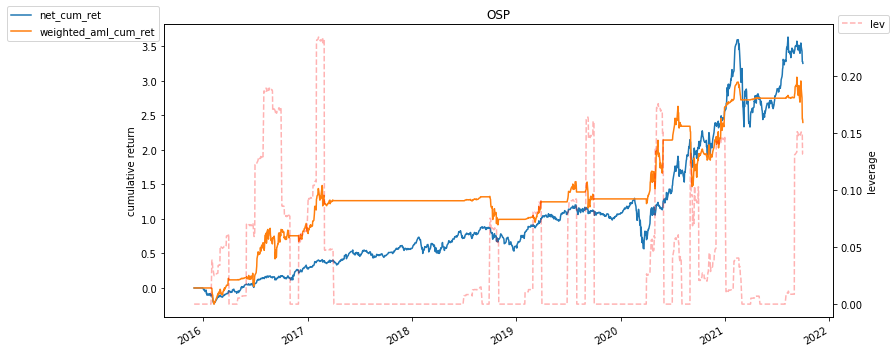

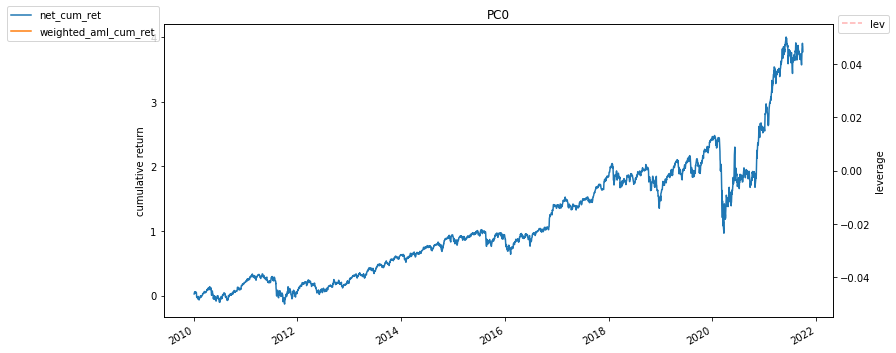

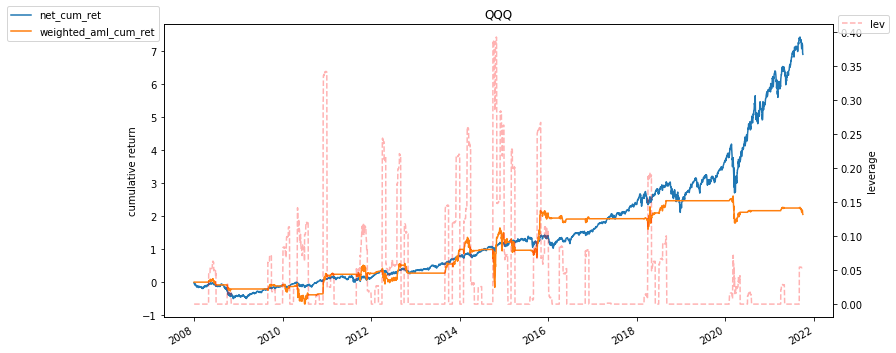

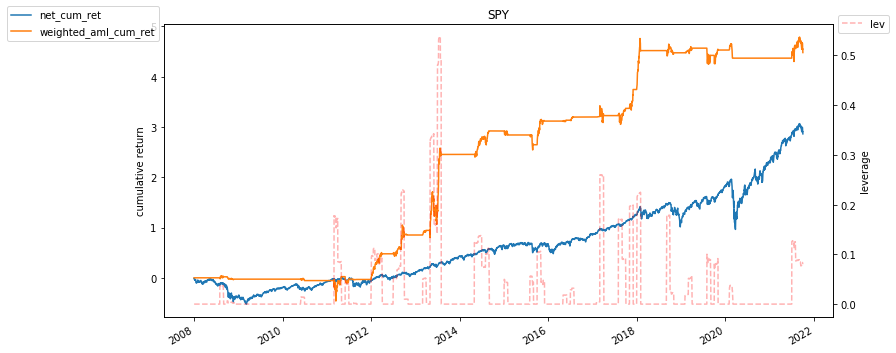

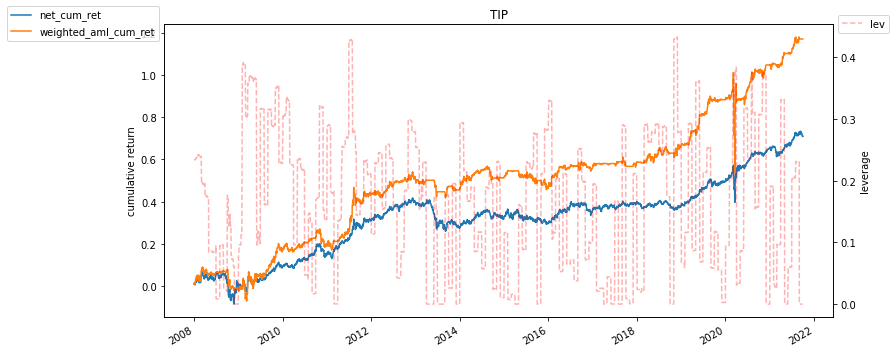

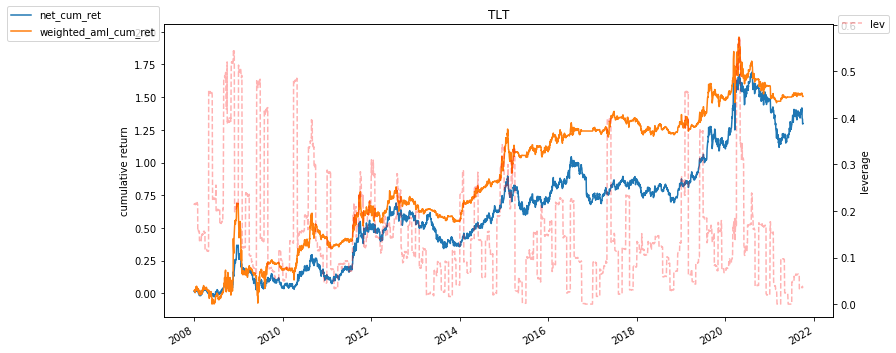

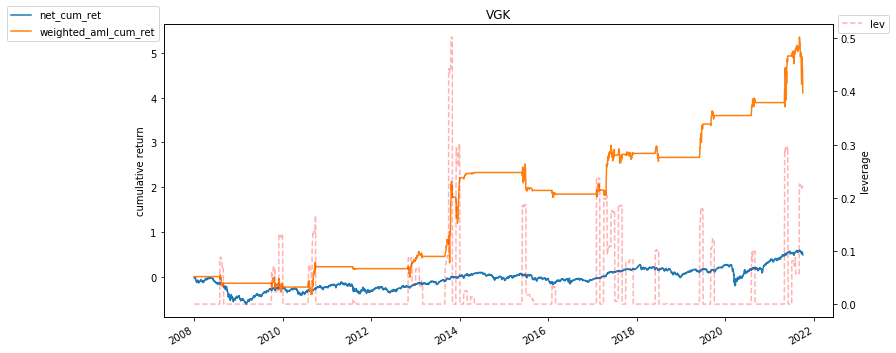

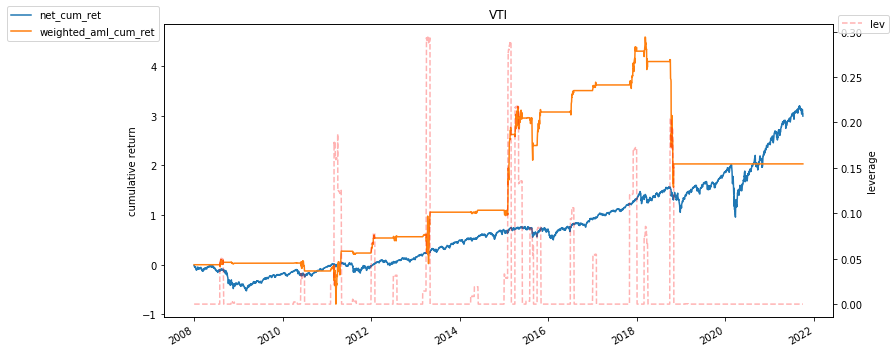

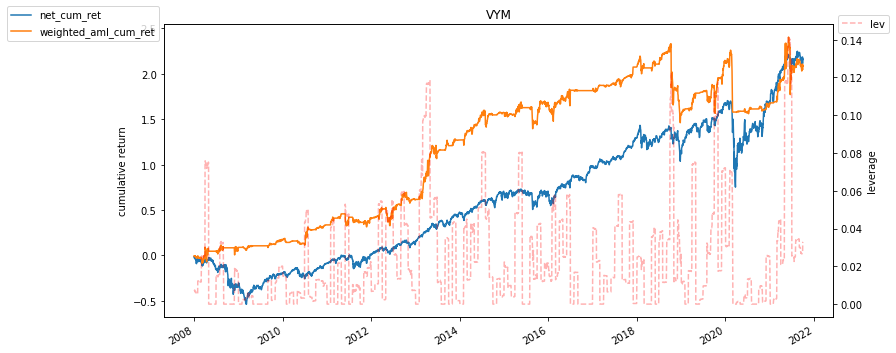

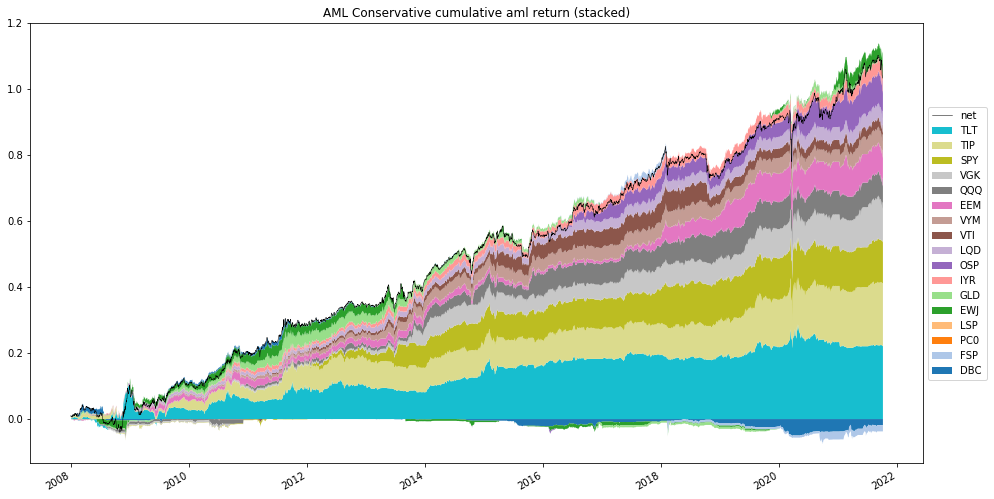

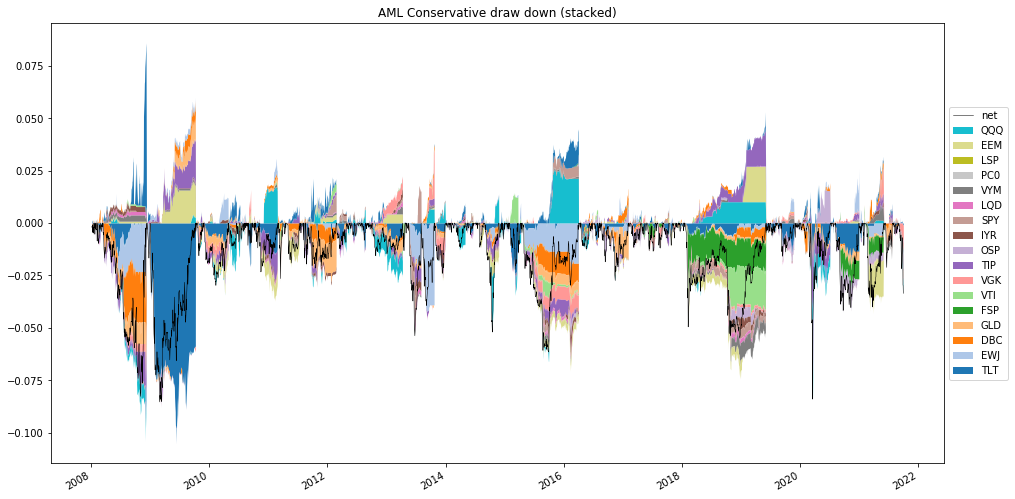

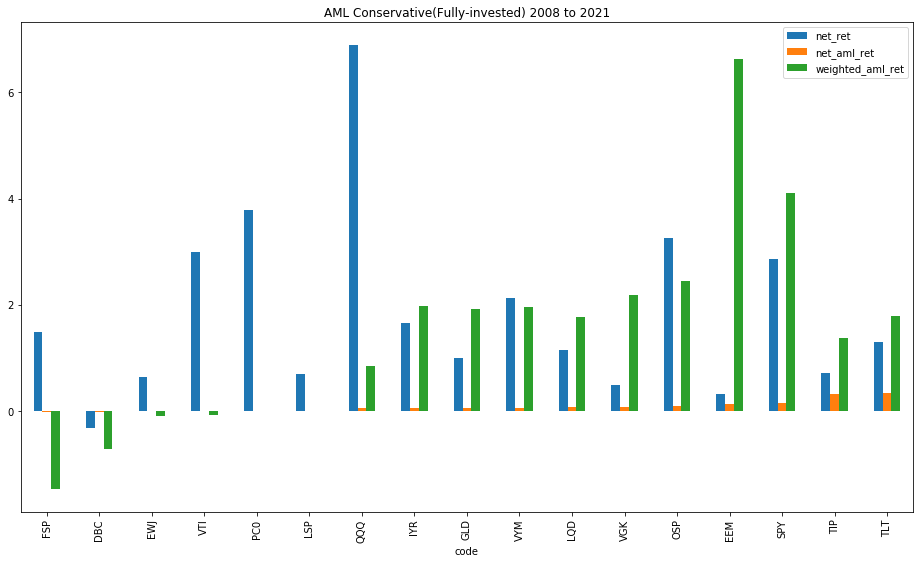

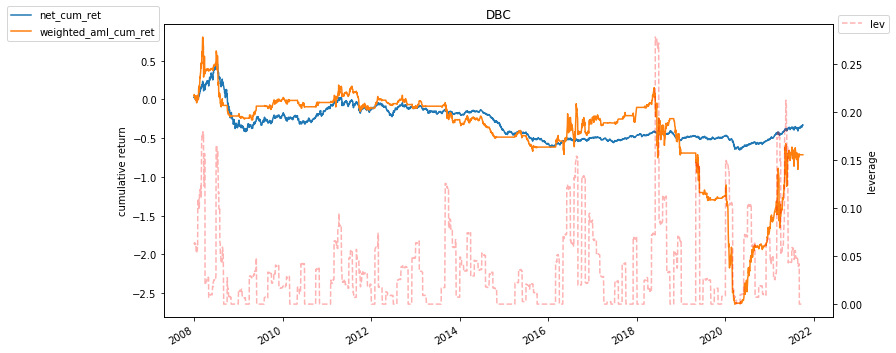

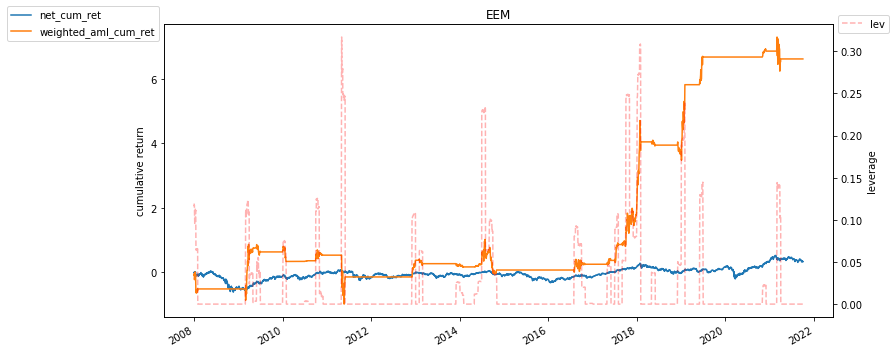

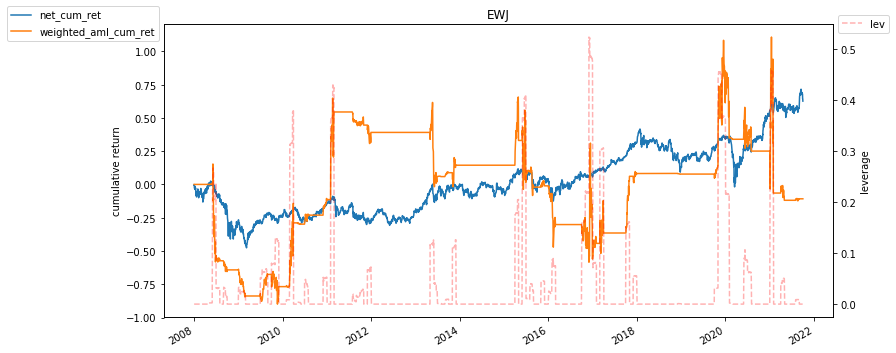

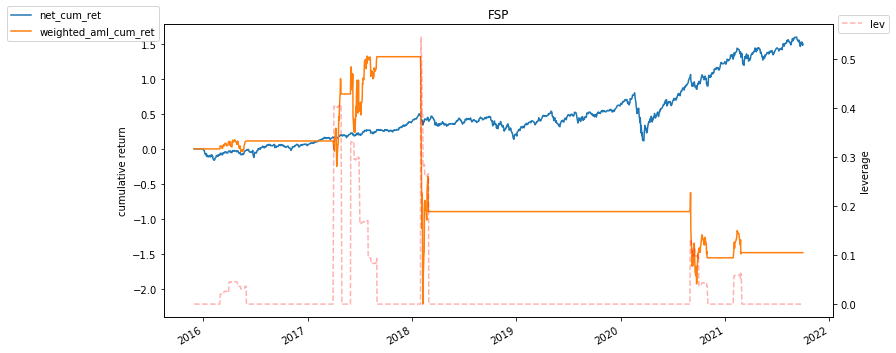

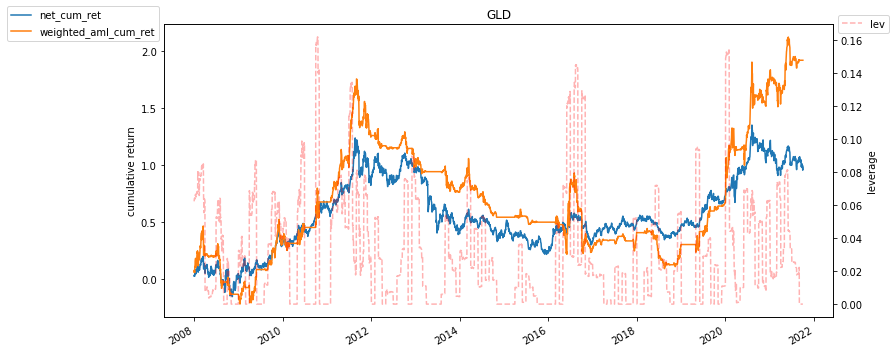

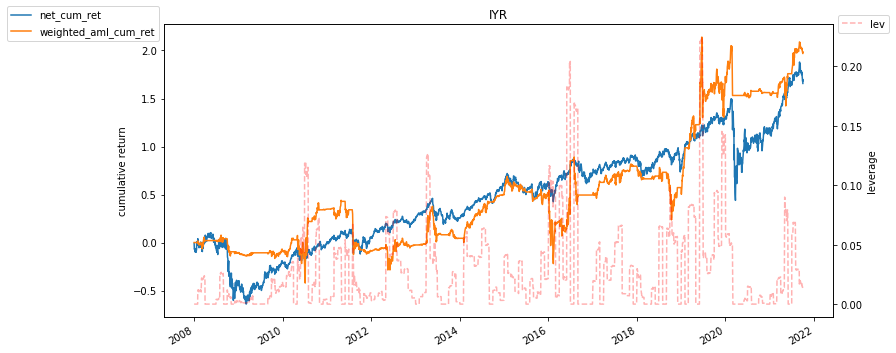

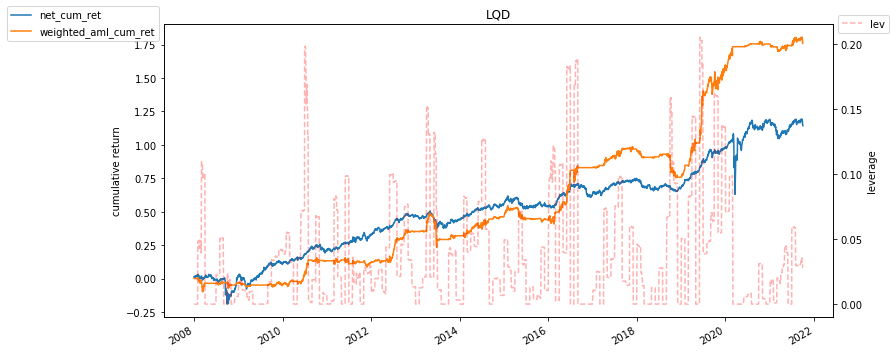

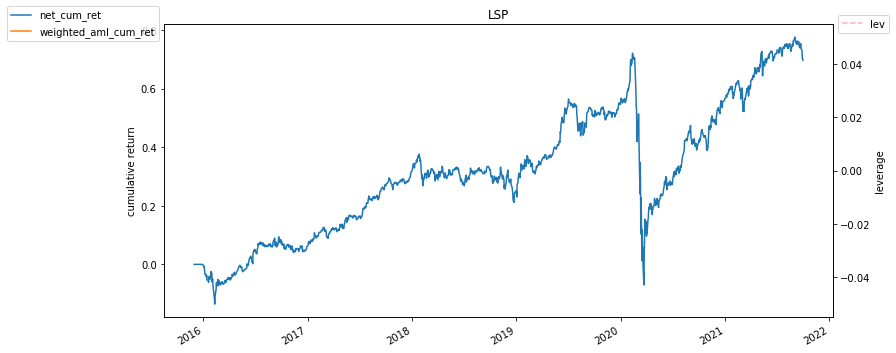

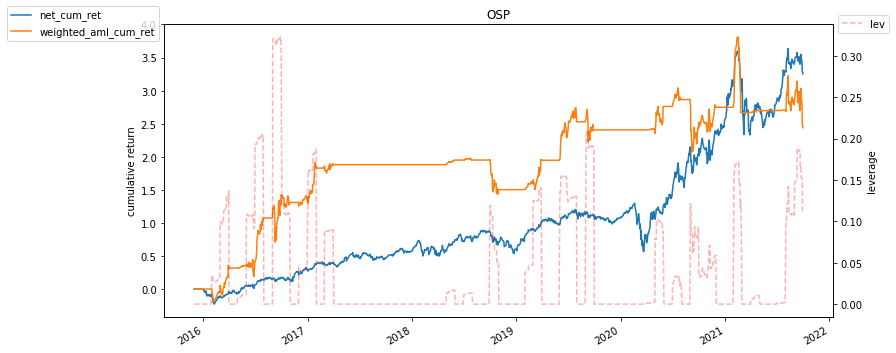

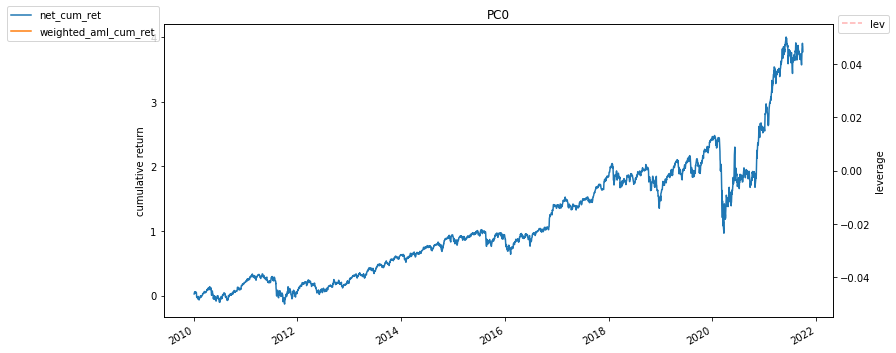

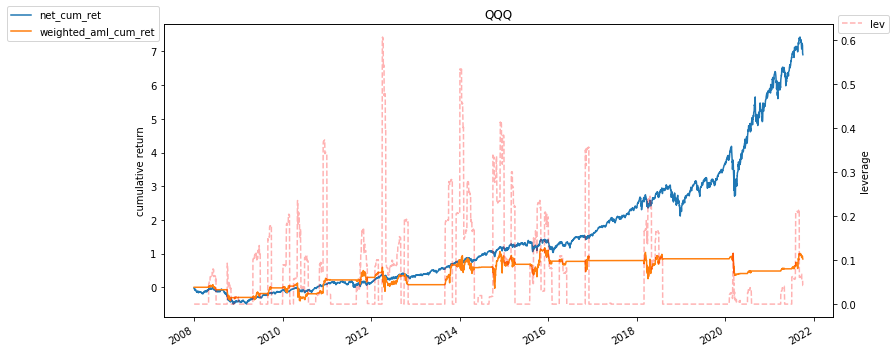

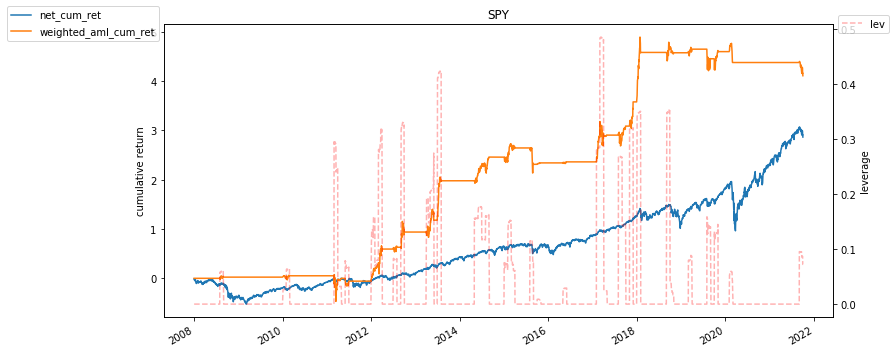

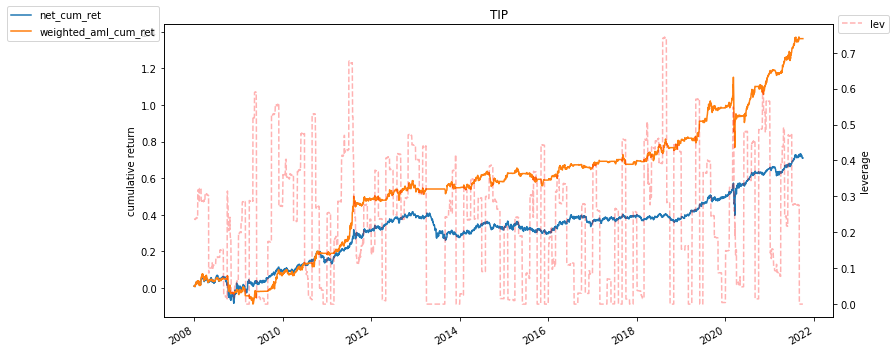

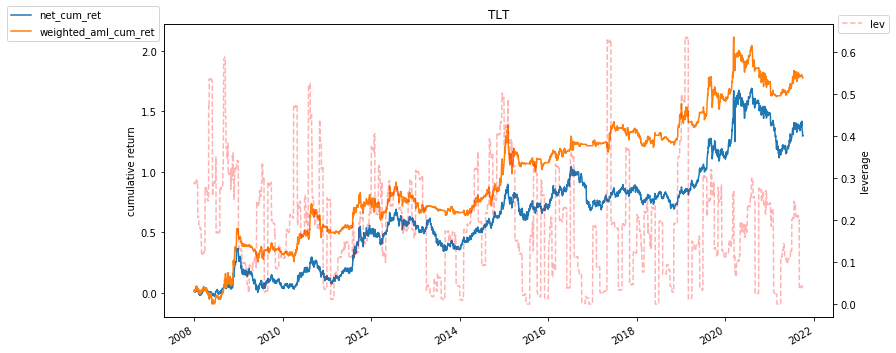

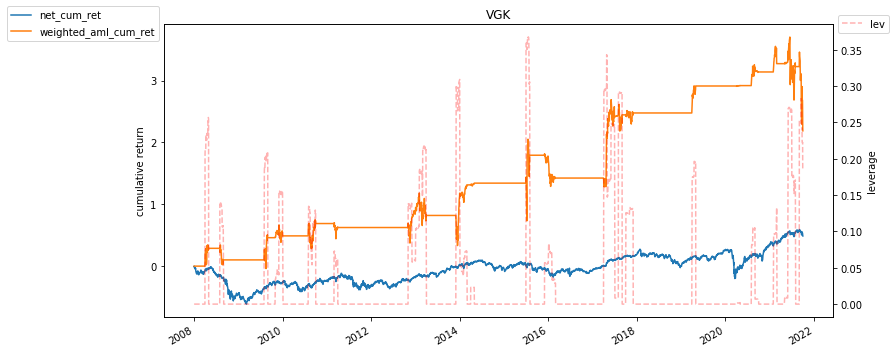

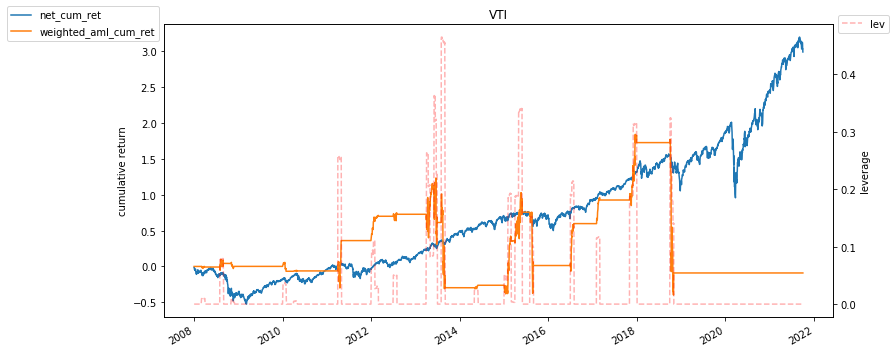

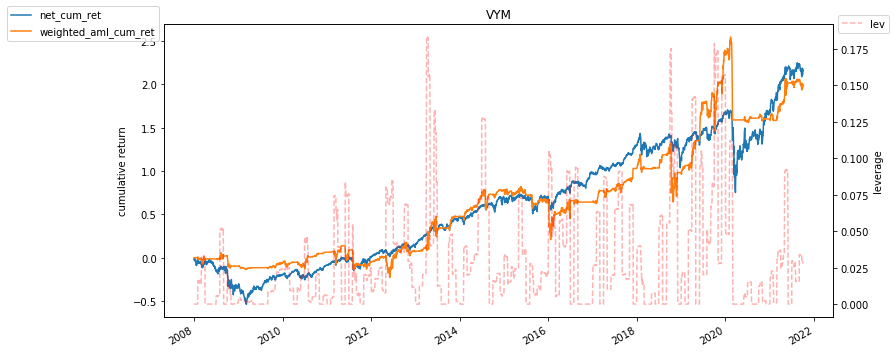

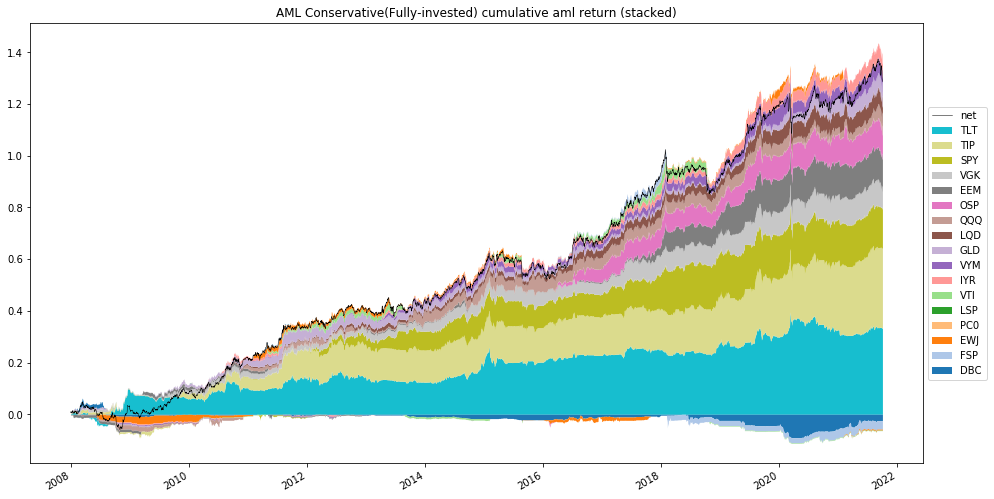

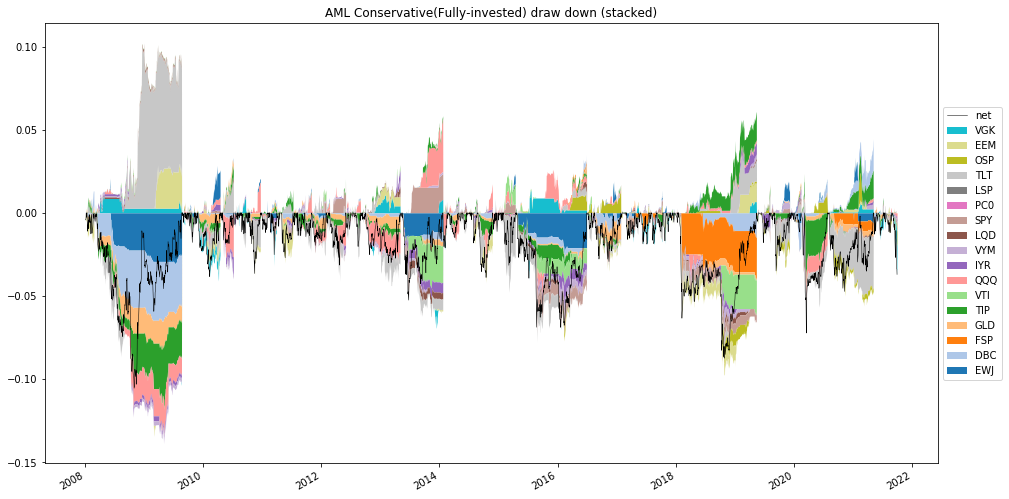

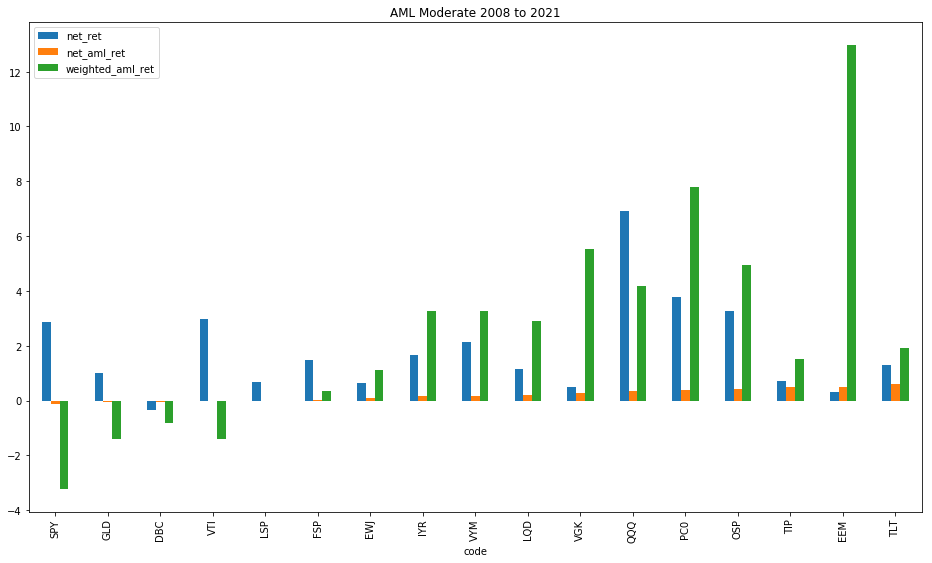

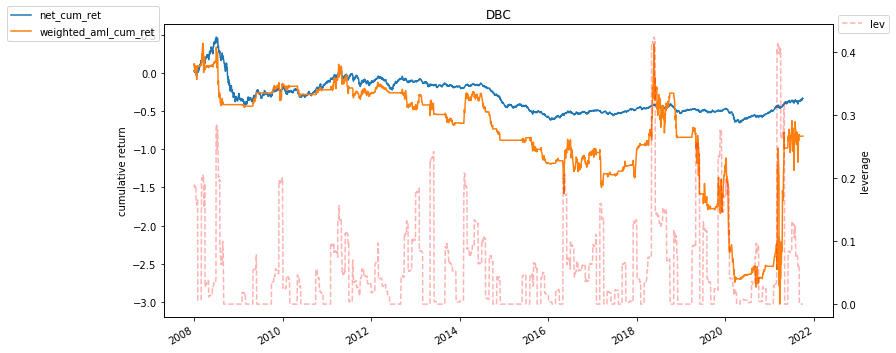

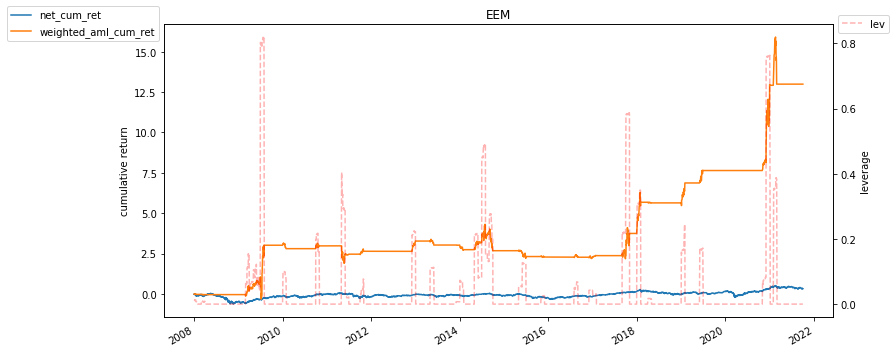

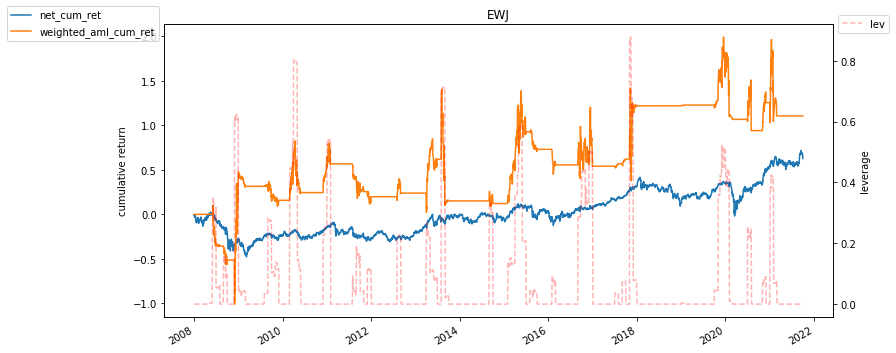

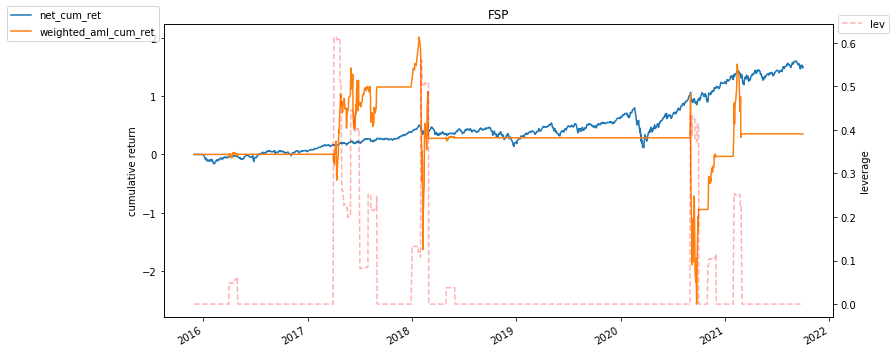

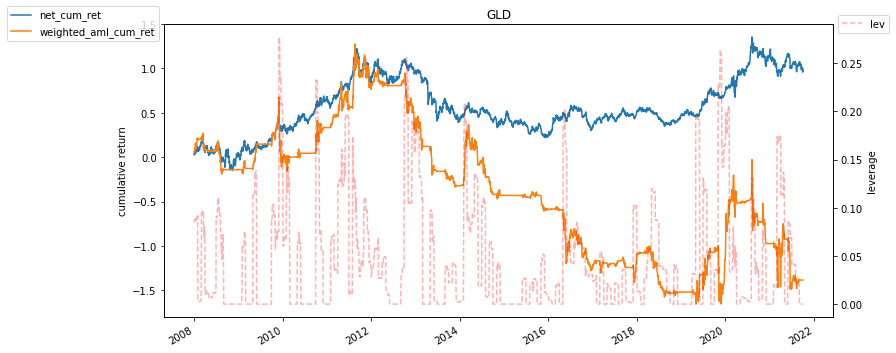

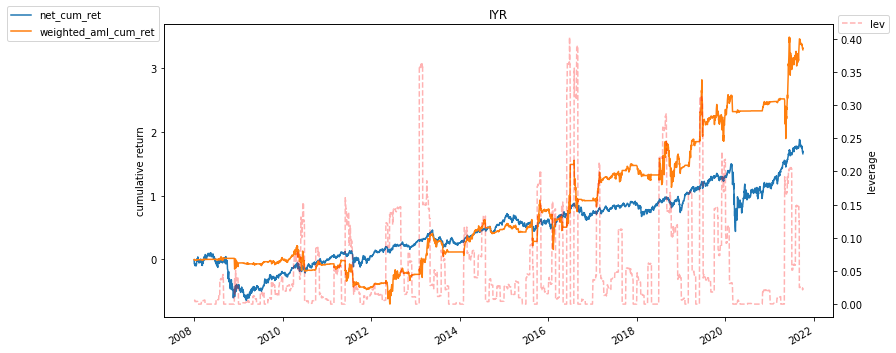

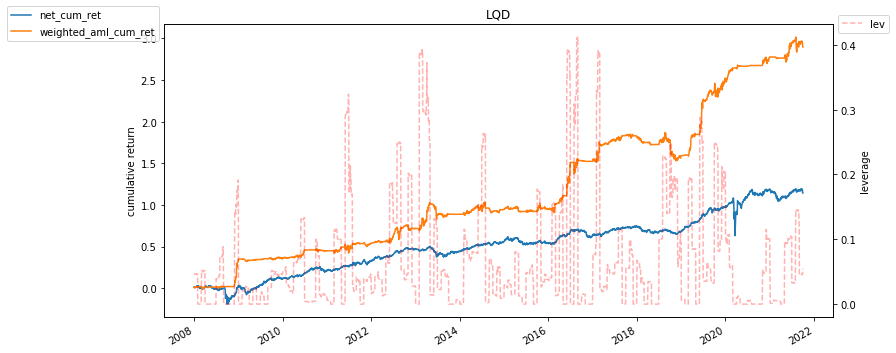

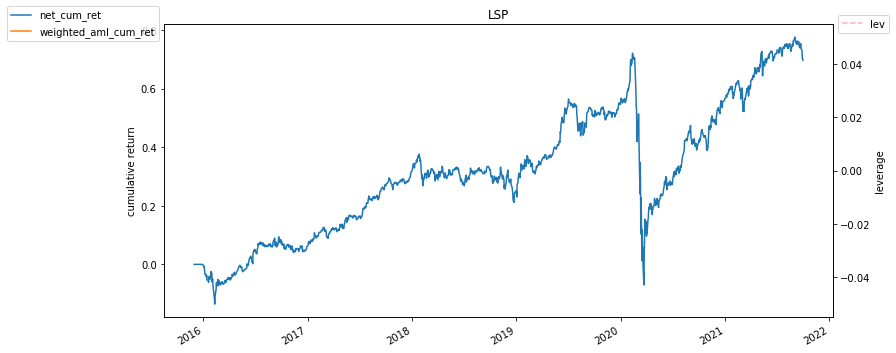

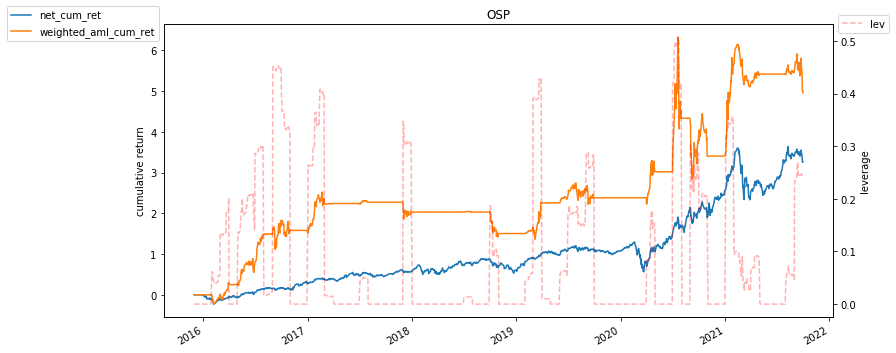

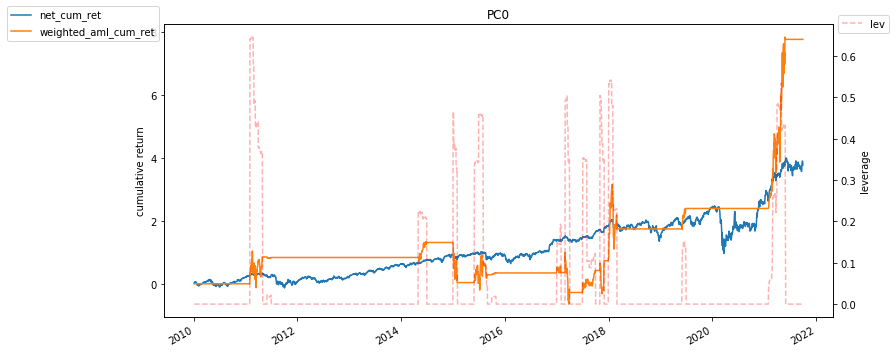

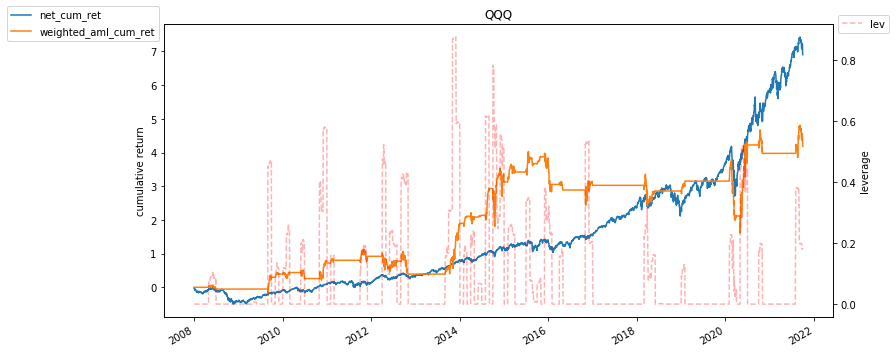

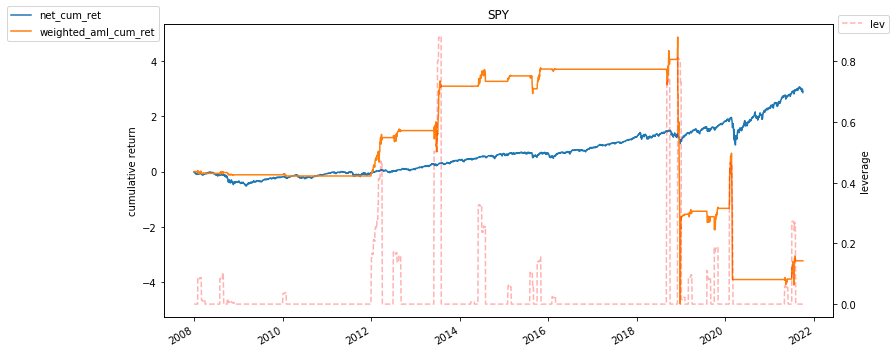

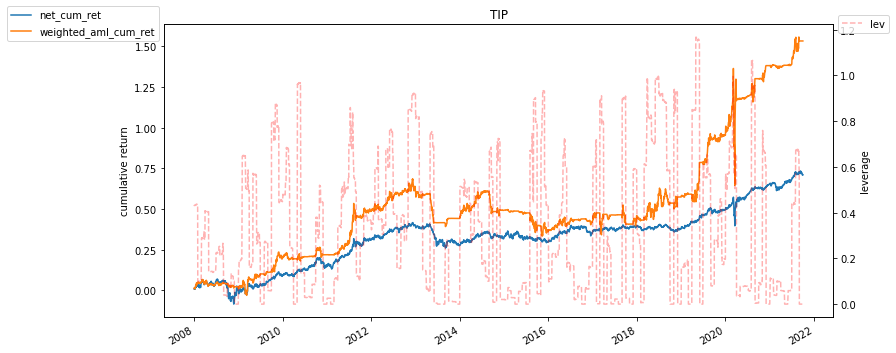

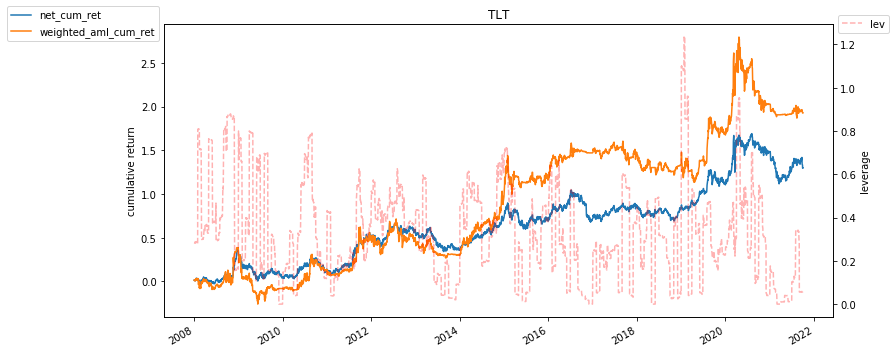

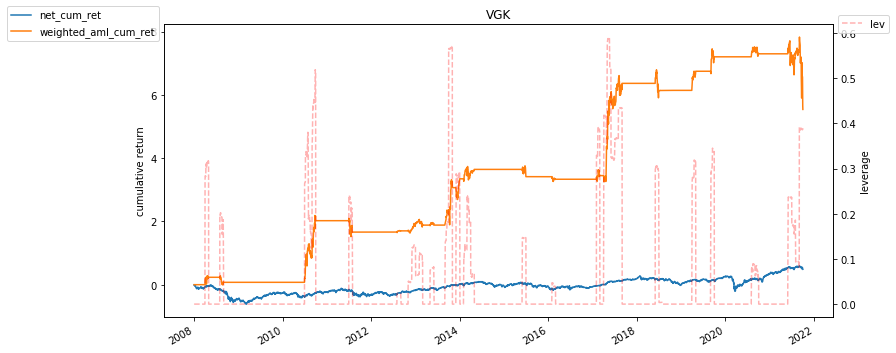

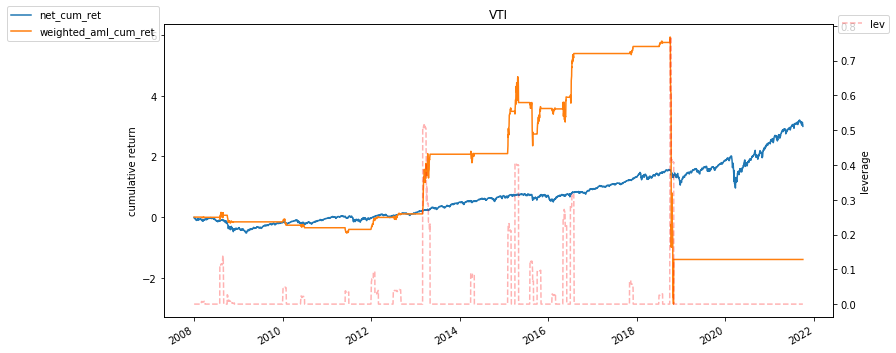

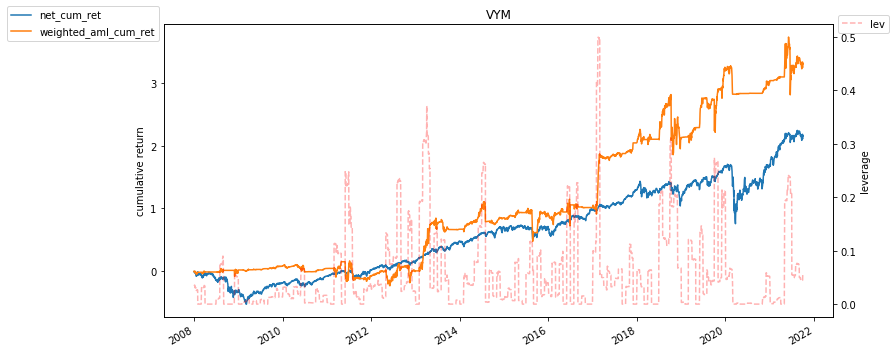

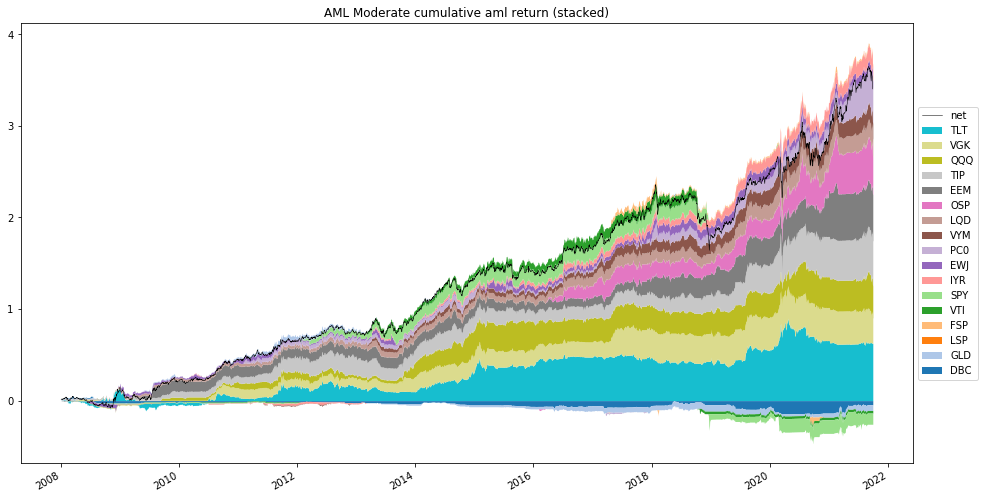

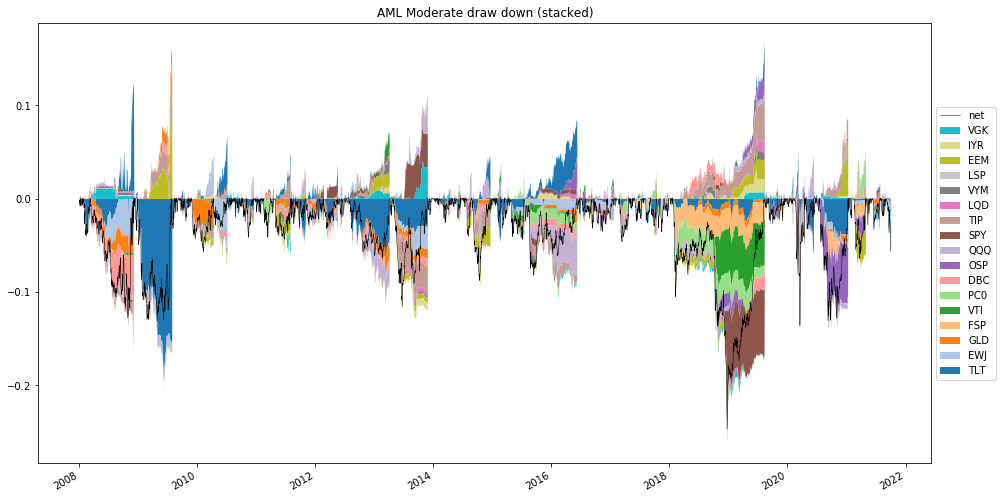

In [43]:
result_all = {}
for f in os.listdir(no3vote_sim):
    e = os.path.join(no3vote_sim, f)
    r, n = plot_all(e, ret)
    result_all[n] = r

## ML accuracy

In [44]:
def get_record(file):
    df = pd.read_csv(file, index_col=0)
    pivot_df = pd.pivot_table(df, values='Real Prediction', index='Trading Date', columns='Symbol')
    pivot_df.index = pd.to_datetime(pivot_df.index, format='%Y-%m-%d')#.date
    return pivot_df

def get_label(dfclose, pp=21):
    dfclose.index = pd.to_datetime(dfclose.index, format='%Y-%m-%d').date
    y_pctch = -dfclose.pct_change(-pp).dropna(how='all')
    y_label = (y_pctch > 0).astype(int)
    return y_label

def get_label_from_file(file, pp=21):
    df = pd.read_csv(file)
    df = df.drop_duplicates(['date', 'code'], keep='last')
    pivot_df = pd.pivot_table(df, values='close', index='date', columns='code')
    
    ylabel = get_label(pivot_df, pp)
    return ylabel

In [45]:
y_df = get_label_from_file(backtest_price)
y_df.index = pd.to_datetime(y_df.index, format='%Y-%m-%d')
y_df.to_csv(os.path.join('data', 'y_label.csv'))

preds = get_record(preds_file)
preds.tail()

Symbol        DBC  EEM  EWJ  FSP  GLD  IYR  LQD  LSP  OSP  PC0  QQQ  SPY  TIP  \
Trading Date                                                                    
2021-09-28    0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
2021-09-29    0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
2021-09-30    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
2021-10-01    0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2021-10-04    0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

Symbol        TLT  VGK  VTI  VYM  
Trading Date                      
2021-09-28    0.0  1.0  1.0  1.0  
2021-09-29    1.0  1.0  1.0  1.0  
2021-09-30    0.0  1.0  1.0  1.0  
2021-10-01    1.0  1.0  1.0  1.0  
2021-10-04    1.0  1.0  1.0  1.0

In [46]:
accframe = pd.Series()
for asset in preds.columns:
    if asset in y_df.columns:
        tt = pd.concat([y_df[asset], preds[asset]], axis=1).dropna()
        accframe[asset] = accuracy_score(tt.iloc[:, 0], tt.iloc[:, 1]).round(2)
accframe.name = 'Accuracy'

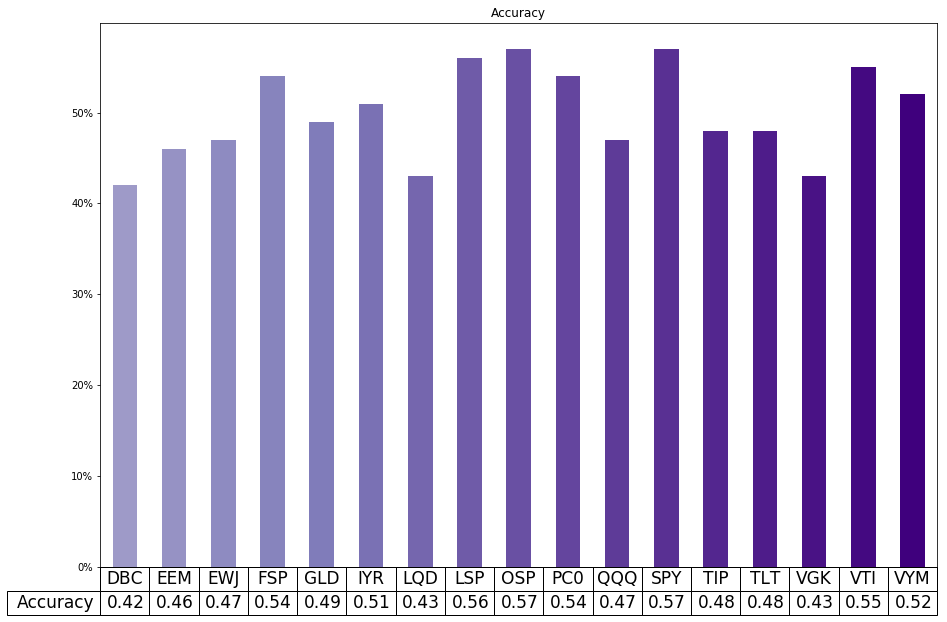

In [47]:
asset_colors = cm.Purples(np.linspace(0.5,1,len(accframe)))
acc = accframe.plot(kind='bar', figsize=(15,10), color=asset_colors, title='Accuracy', table=True)
acc.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
acc.axes.get_xaxis().set_visible(False)
# acc.axes.get_yaxis().set_visible(False)
acc.tables[0].set_fontsize(20)
acc.tables[0].scale(1,2)

## 3VOTES

In [48]:
set_year = set()
set_month = set()

yc = 2
mc = 2

client_ = 'agg'

# get no 3vote file
for ef in os.listdir(no3vote_sim):
    if client_ in ef:
        excel0 = os.path.join(no3vote_sim, ef)
print("No 3vote file: ", excel0)

# get 3vote file
for ef in os.listdir(sim_fn):
    if client_ in ef:
        excel1 = os.path.join(sim_fn, ef)
print("3vote file: ", excel1)

No 3vote file:  sim\1.4.6\digital_twins_KPIs_zzzg0125top25_agg.xlsx
3vote file:  sim\1.4.7\digital_twins_KPIs_zzzg0125top25v02_agg.xlsx


### 3vote better than no 3vote year

In [49]:
ykpi0 = pd.read_excel(excel0, sheet_name='KPI(Annually)', index_col=0)

ys = ykpi0.sort_values('Annual Return')[:yc].index
set_year = set_year | set(ys)
#ys = ykpi0.sort_values('Annual Return')[-yc:].index
#set_year = set_year | set(ys)

ys = ykpi0.sort_values('Sharpe')[:yc].index
set_year = set_year | set(ys)
#ys = ykpi0.sort_values('Sharpe')[-yc:].index
#set_year = set_year | set(ys)

ys = ykpi0.sort_values('Max-DD')[:yc].index
set_year = set_year | set(ys)
#ys = ykpi0.sort_values('Max-DD')[-yc:].index
#set_year = set_year | set(ys)

set_year
#ykpi0

{2013, 2015, 2018}

In [50]:
ykpi1 = pd.read_excel(excel1, sheet_name='KPI(Annually)', index_col=0)

ys = ykpi1.sort_values('Annual Return')[:yc].index
set_year = set_year | set(ys)
#ys = ykpi1.sort_values('Annual Return')[-yc:].index
#set_year = set_year | set(ys)

ys = ykpi1.sort_values('Sharpe')[:yc].index
set_year = set_year | set(ys)
#ys = ykpi1.sort_values('Sharpe')[-yc:].index
#set_year = set_year | set(ys)

ys = ykpi1.sort_values('Max-DD')[:yc].index
set_year = set_year | set(ys)
#ys = ykpi1.sort_values('Max-DD')[-yc:].index
#set_year = set_year | set(ys)

set_year
#ykpi1

{2013, 2015, 2018, 2020}

In [51]:
#ys = (ykpi1-ykpi0).sort_values('Annual Return')[:yc].index
#set_year = set_year | set(ys)
ys = (ykpi1-ykpi0).sort_values('Annual Return')[-yc:].index
set_year = set_year | set(ys)

#ys = (ykpi1-ykpi0).sort_values('Sharpe')[:yc].index
#set_year = set_year | set(ys)
ys = (ykpi1-ykpi0).sort_values('Sharpe')[-yc:].index
set_year = set_year | set(ys)

#ys = (ykpi1-ykpi0).sort_values('Max-DD')[:yc].index
#set_year = set_year | set(ys)
ys = (ykpi1-ykpi0).sort_values('Max-DD')[-yc:].index
set_year = set_year | set(ys)

set_year
#ykpi1

{2008, 2009, 2011, 2013, 2015, 2018, 2020}

In [52]:
list_year = list(set_year)
list_year.sort()

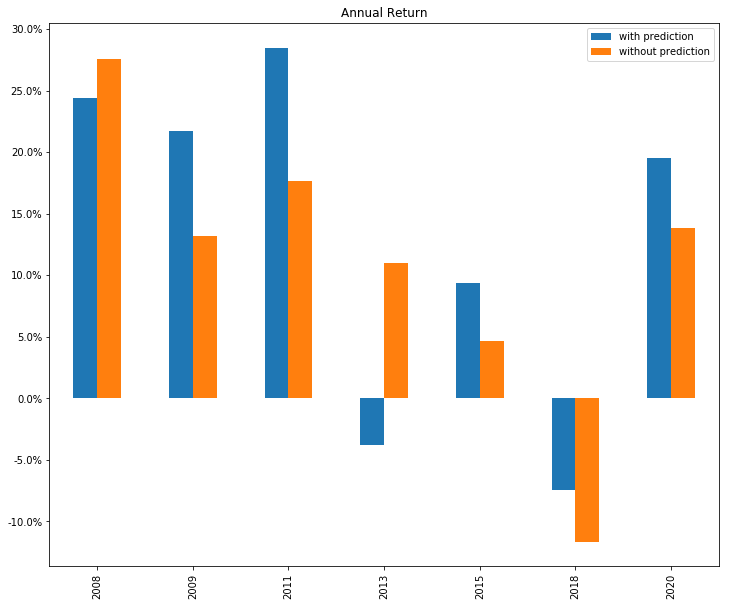

In [53]:
df = pd.concat([ykpi1['Annual Return'], ykpi0['Annual Return']], 1, keys=['with prediction','without prediction']).loc[list_year]
chart = df.plot.bar(title='Annual Return', figsize=(12,10))
chart.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

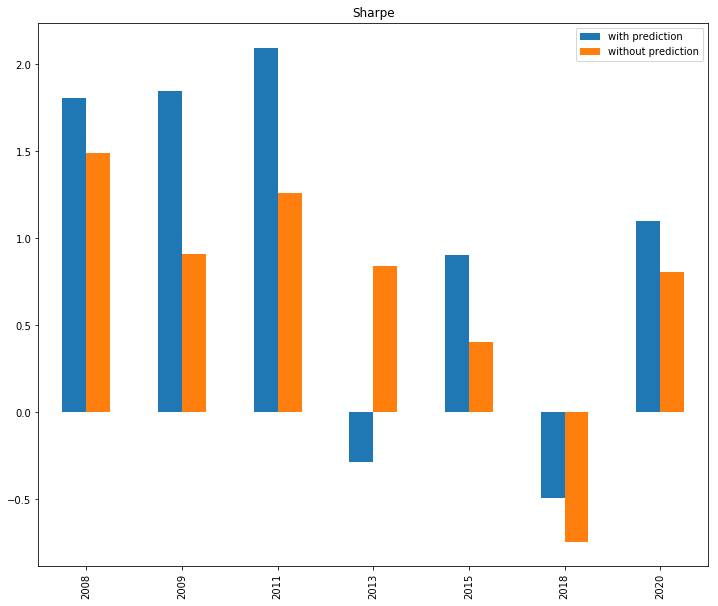

In [54]:
df = pd.concat([ykpi1['Sharpe'], ykpi0['Sharpe']], 1, keys=['with prediction','without prediction']).loc[list_year]
chart = df.plot.bar(title='Sharpe', figsize=(12,10))

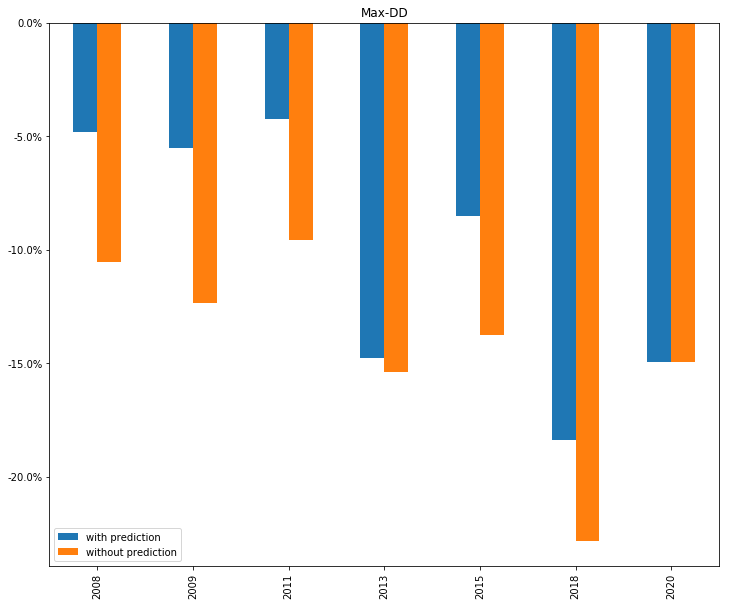

In [55]:
df = pd.concat([ykpi1['Max-DD'], ykpi0['Max-DD']], 1, keys=['with prediction','without prediction']).loc[list_year]
chart = df.plot.bar(title='Max-DD', figsize=(12,10))
chart.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

### big crash year

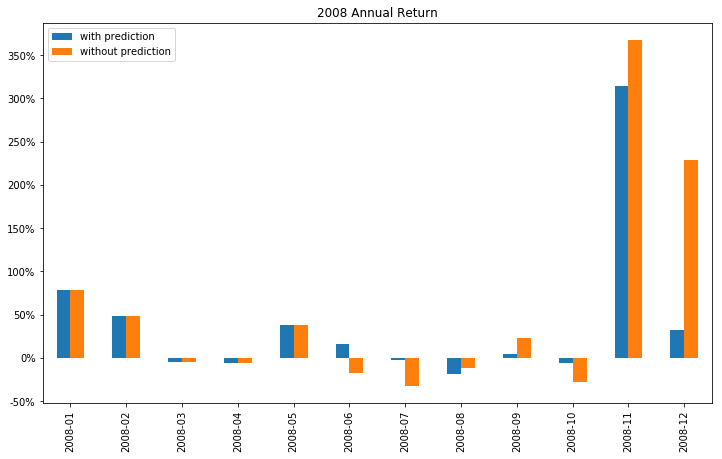

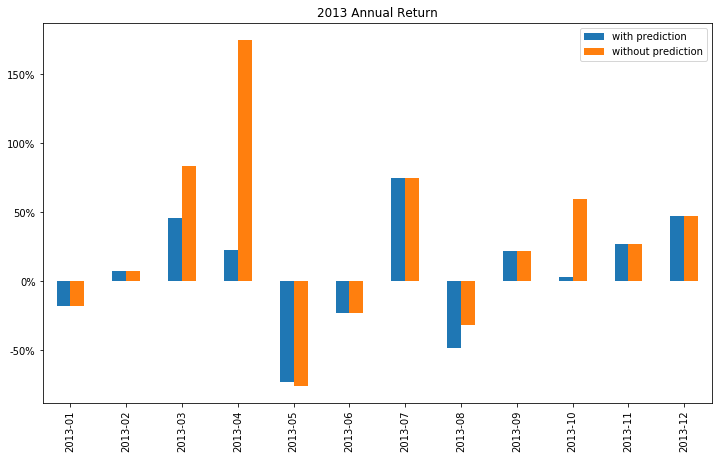

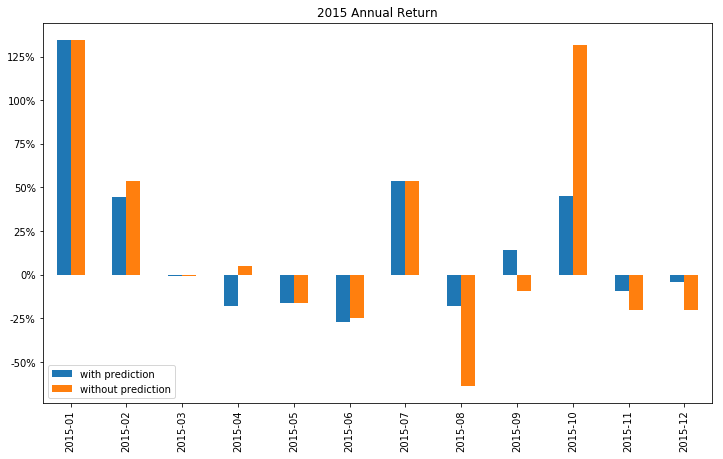

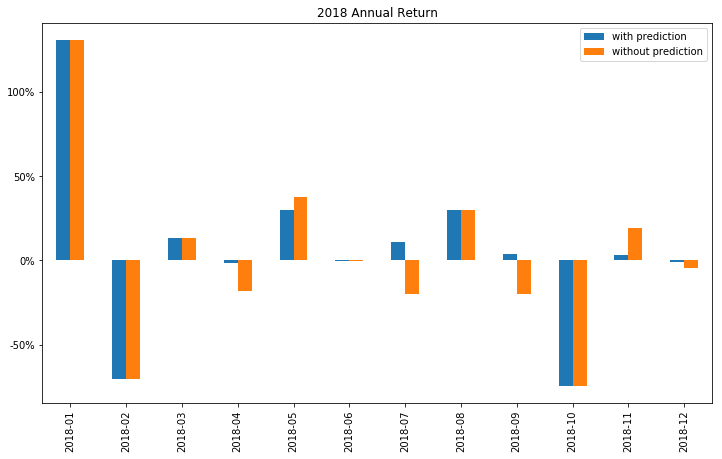

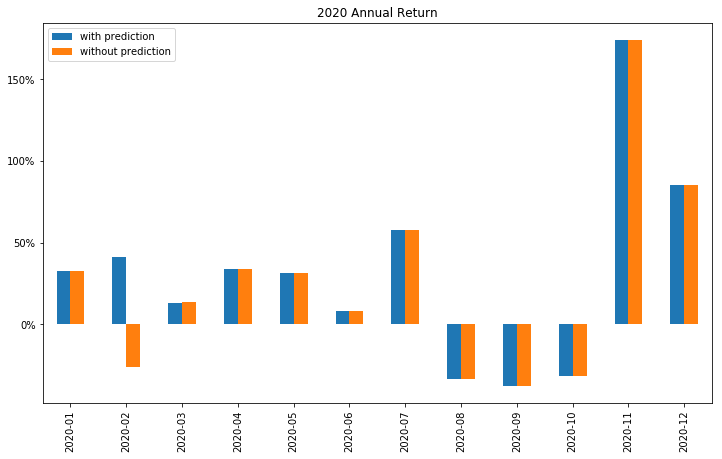

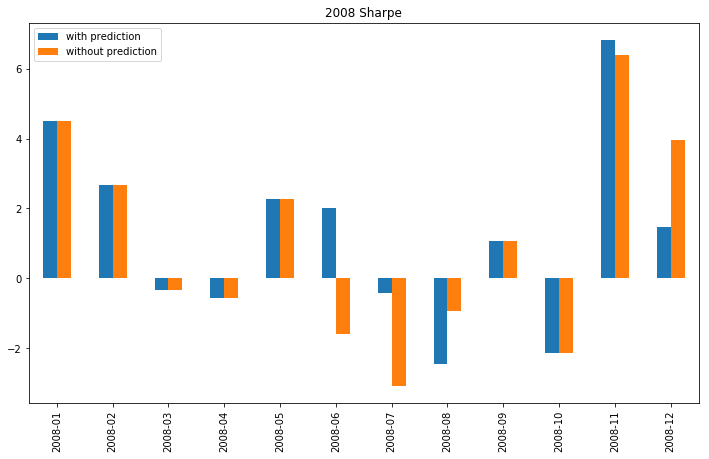

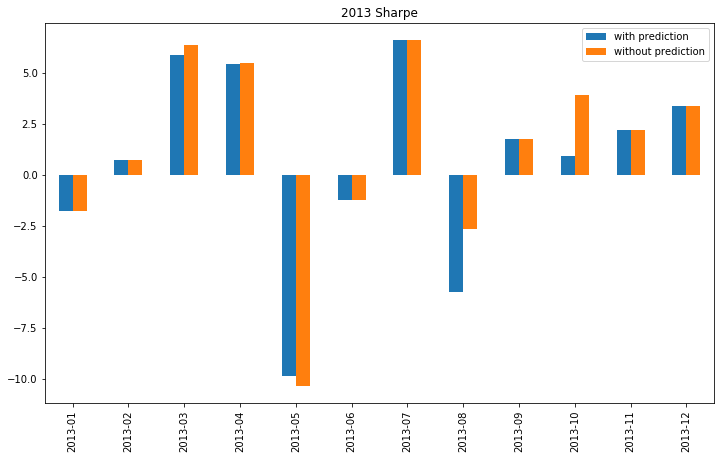

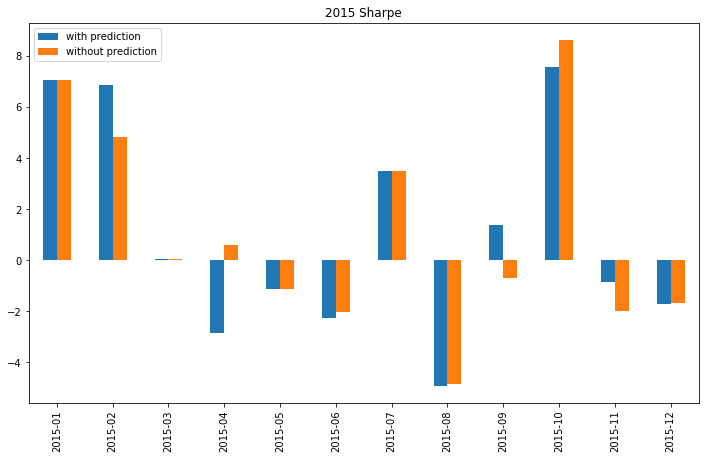

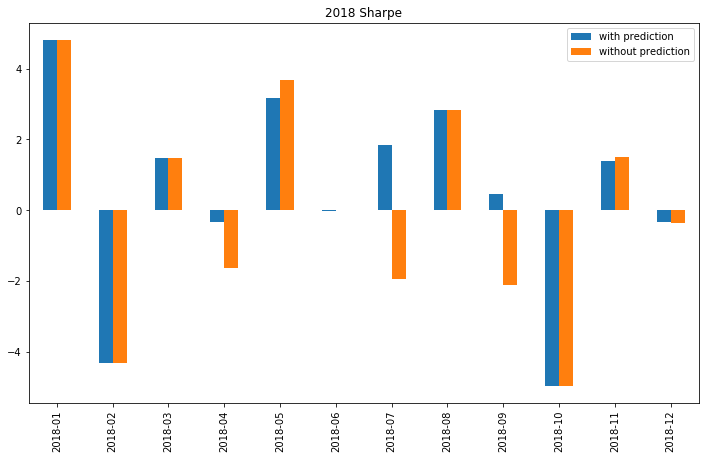

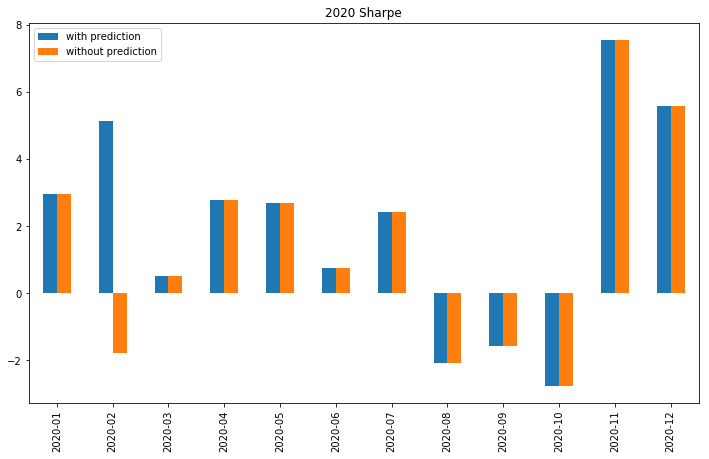

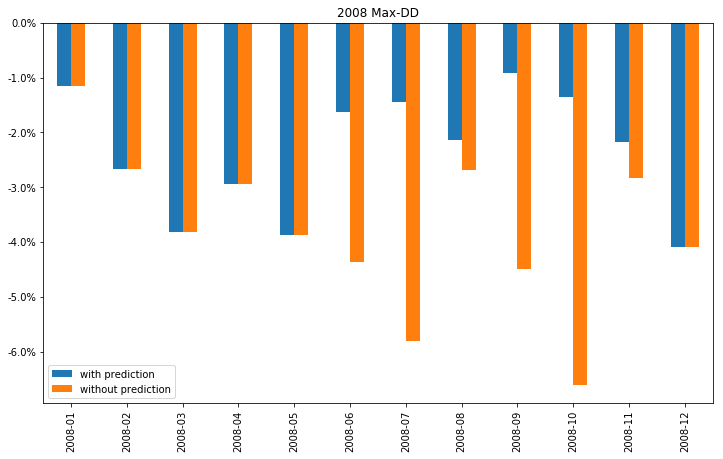

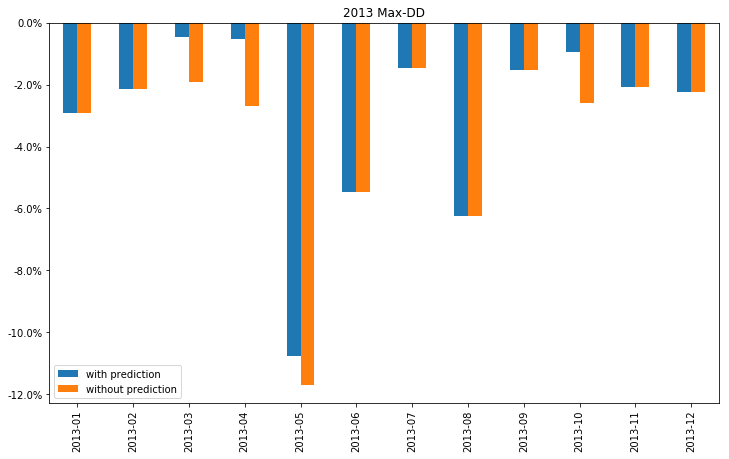

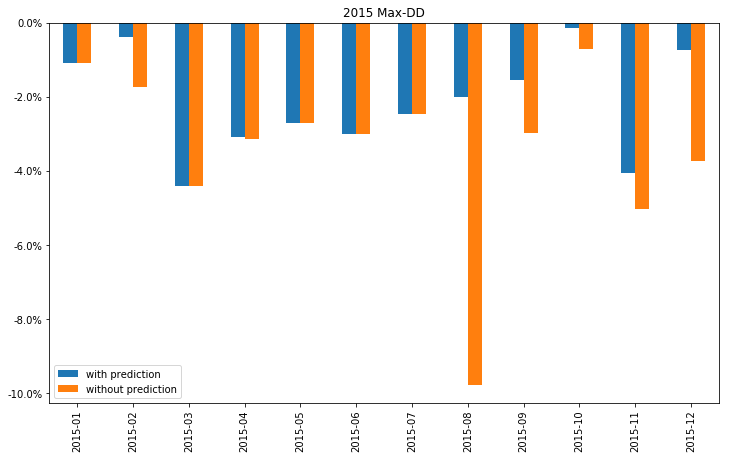

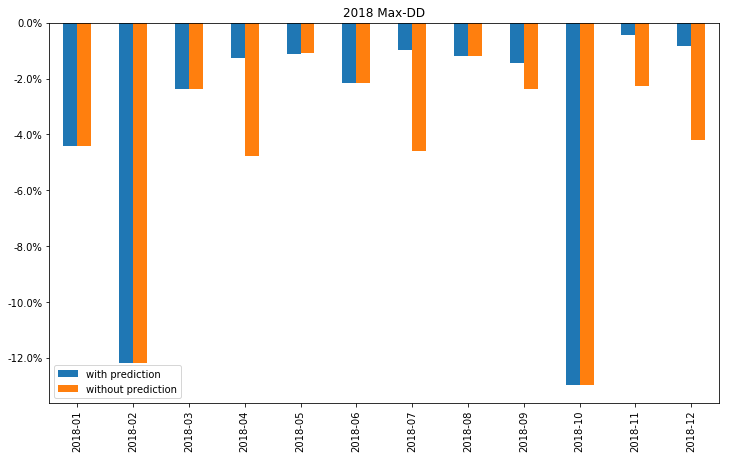

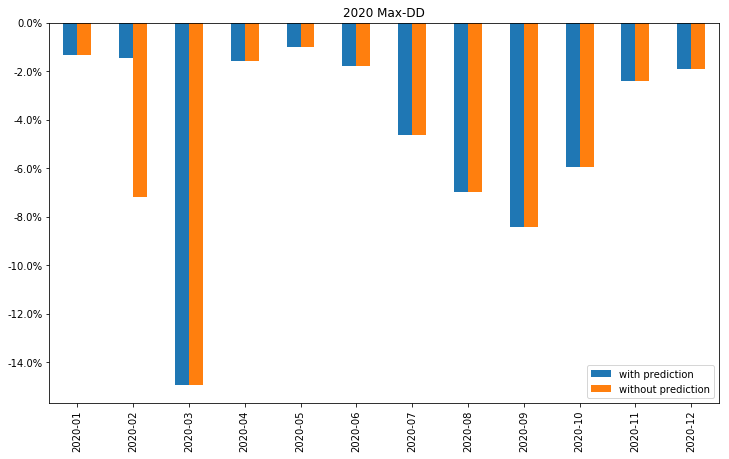

In [56]:
mkpi0 = pd.read_excel(excel0, sheet_name='KPI(Monthly)', index_col=0)
mkpi1 = pd.read_excel(excel1, sheet_name='KPI(Monthly)', index_col=0)

for k in ['Annual Return', 'Sharpe', 'Max-DD']:
    for y in ['2008','2013','2015','2018','2020']:
        yms = [ym for ym in mkpi0.index if ym.startswith(y)]
        df = pd.concat([mkpi1[k], mkpi0[k]], 1, keys=['with prediction','without prediction']).loc[yms]
        if k != 'Sharpe':
            chart = df.plot.bar(title=y+' '+k, figsize=(12,7))
            chart.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
        else:
            df.plot.bar(title=y+' '+k, figsize=(12,7))